In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# LOAD & LONG-FORM TRANSFORM
PATH = "france_pay_equity_scored_NOVEMBER2025.csv"
df = pd.read_csv(PATH, low_memory=False)

# Detect years from any "YYYY_*" column
YEARS = sorted({
    int(c.split("_", 1)[0])
    for c in df.columns
    if len(c) >= 5 and c[:4].isdigit() and "_" in c
})
print("Detected years:", YEARS)


Detected years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [3]:
# Helper for year-specific columns
def get_year_col(y: int, suffix: str):
    col = f"{y}_{suffix}"
    return df[col] if col in df.columns else np.nan

def get_composite_index_for_year(y: int):
    # Prefer numeric field if present
    num_col = f"{y}_CompositeIndex_num"
    base_col = f"{y}_CompositeIndex"
    if num_col in df.columns:
        return df[num_col]
    elif base_col in df.columns:
        return df[base_col]
    else:
        return np.nan

In [4]:
# France note suffixes (exact strings from the CSV)
REM_SUFFIX   = "Note Ecart rémunération"
PROMO_SUFFIX = "Note Ecart taux de promotion"
RAISE_SUFFIX = "Note Ecart taux d'augmentation"
MAT_SUFFIX   = "Note Retour congé maternité"
HIGH_SUFFIX  = "Note Hautes rémunérations"

long_rows = []
for y in YEARS:
    tmp = pd.DataFrame({
        "EmployerId": df["EmployerId"],
        "Year": y,
        # Core component scores
        "Score_WageGap":          get_year_col(y, REM_SUFFIX),
        "Score_PromotionGap":     get_year_col(y, PROMO_SUFFIX),
        "Score_RaiseGap":         get_year_col(y, RAISE_SUFFIX),
        "Score_MaternityReturn":  get_year_col(y, MAT_SUFFIX),
        "Score_HighEarners":      get_year_col(y, HIGH_SUFFIX),
        "CompositeIndex":         get_composite_index_for_year(y),
        # Context
        "EmployerSize":           get_year_col(y, "EmployerSize"),
        "Region":                 get_year_col(y, "Region"),
        "Departement":            get_year_col(y, "Département"),
        "TrendCategory":          df.get("TrendCategory", pd.Series([np.nan]*len(df))),
        "PrimarySicCode":         df.get("PrimarySicCode", pd.Series([np.nan]*len(df))),
    })
    long_rows.append(tmp)

long_df = pd.concat(long_rows, ignore_index=True)

In [5]:
# Ensure numeric for all score fields
score_cols = [
    "Score_WageGap",
    "Score_PromotionGap",
    "Score_RaiseGap",
    "Score_MaternityReturn",
    "Score_HighEarners",
    "CompositeIndex",
]
for c in score_cols:
    long_df[c] = pd.to_numeric(long_df[c], errors="coerce")

latest_year = long_df["Year"].max()
latest_mask = long_df["Year"] == latest_year
print("Latest reporting year:", latest_year)

Latest reporting year: 2024


**Data Quality & Coverage**

=== Overall Missingness (Top 30 columns) ===
                                MissingCount  MissingPercent
CreativeSignalsScore                   39848           100.0
LeadershipStabilityScore               39848           100.0
LeadershipEngagementScore              39848           100.0
ReportingQualityScore                  39848           100.0
StructuralEquityScore                  39848           100.0
IndustryLeadershipScore                39848           100.0
2024_DateSubmitted                     39848           100.0
2024_DueDate                           39848           100.0
2024_SubmittedAfterTheDeadline         39848           100.0
2024_CurrentName                       39848           100.0
2024_ResponsiblePerson                 39848           100.0
2024_CompanyLinkToGPGInfo              39848           100.0
2024_FemaleTopQuartile                 39848           100.0
2018_DateSubmitted                     39848           100.0
2018_DueDate                           3

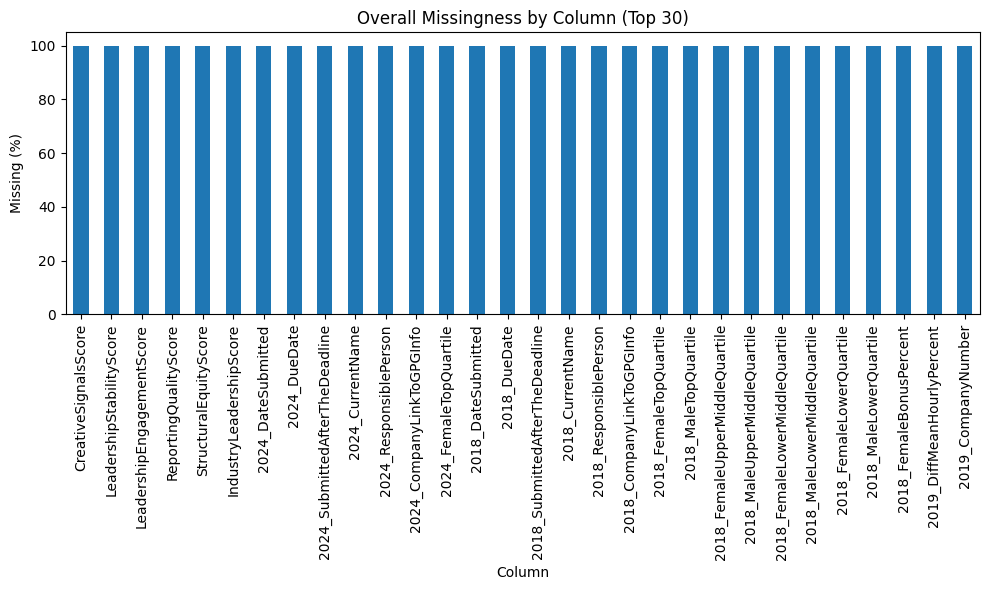

In [6]:
#Missingness by column (wide table)
missing_counts = df.isna().sum()
missing_pct = df.isna().mean() * 100

missing_summary = (
    pd.DataFrame({
        "MissingCount": missing_counts,
        "MissingPercent": missing_pct
    })
    .sort_values("MissingPercent", ascending=False)
)

print("=== Overall Missingness (Top 30 columns) ===")
print(missing_summary.head(30))

plt.figure()
missing_summary["MissingPercent"].head(30).plot(kind="bar")
plt.title("Overall Missingness by Column (Top 30)")
plt.ylabel("Missing (%)")
plt.xlabel("Column")
plt.ylim(0)  # y-axis starts at 0
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


=== Missingness by Year & Component (% missing) ===
      Score_WageGap  Score_PromotionGap  Score_RaiseGap  \
Year                                                      
2018      84.506123           86.601586       98.742722   
2019      54.085525           86.318008       55.556113   
2020      52.268621           85.730777       52.700261   
2021      50.830656           85.168641       50.579703   
2022      48.519374           84.729472       47.440273   
2023      46.858061           84.375627       47.447802   
2024      45.736298           84.167336       47.229472   

      Score_MaternityReturn  Score_HighEarners  CompositeIndex  
Year                                                            
2018              86.739611          82.877434       85.730777  
2019              63.809978          32.980325       57.094459  
2020              63.789902          28.513351       55.483337  
2021              61.676872          27.108010       53.410460  
2022              57.4307

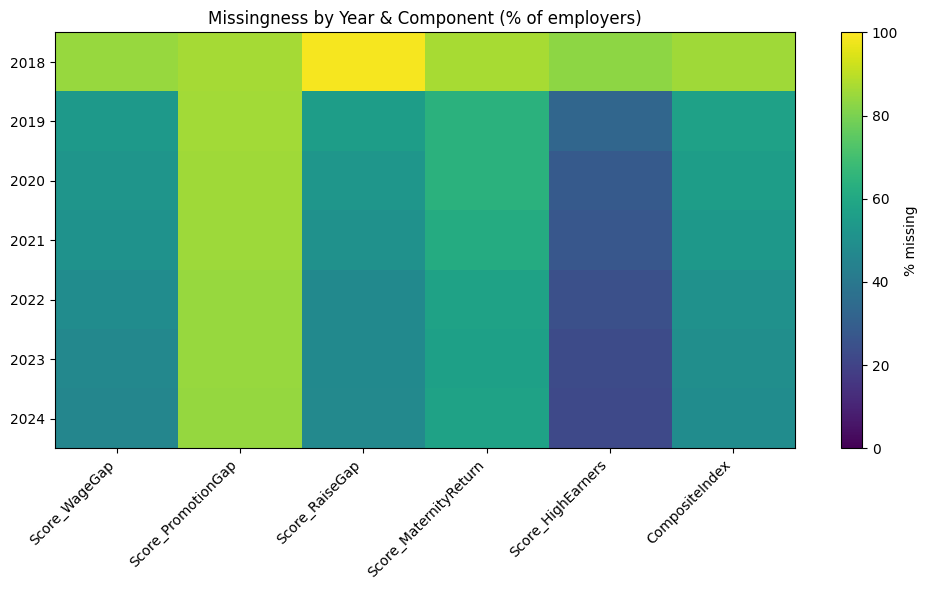

In [7]:
#Missingness by year and component scores
key_score_cols = score_cols  # scores + CompositeIndex

miss_by_year = (
    long_df[["Year"] + key_score_cols]
    .groupby("Year")[key_score_cols]
    .apply(lambda g: g.isna().mean() * 100)
)

print("\n=== Missingness by Year & Component (% missing) ===")
print(miss_by_year)

plt.figure(figsize=(10, 6))
im = plt.imshow(miss_by_year.values, aspect="auto", vmin=0, vmax=100)
plt.xticks(range(len(key_score_cols)), key_score_cols, rotation=45, ha="right")
plt.yticks(range(len(miss_by_year.index)), miss_by_year.index)
plt.title("Missingness by Year & Component (% of employers)")
cbar = plt.colorbar(im)
cbar.set_label("% missing")
plt.tight_layout()
plt.show()


=== Employer count per year ===
Year
2018    39848
2019    39848
2020    39848
2021    39848
2022    39848
2023    39848
2024    39848
Name: EmployerCount, dtype: int64


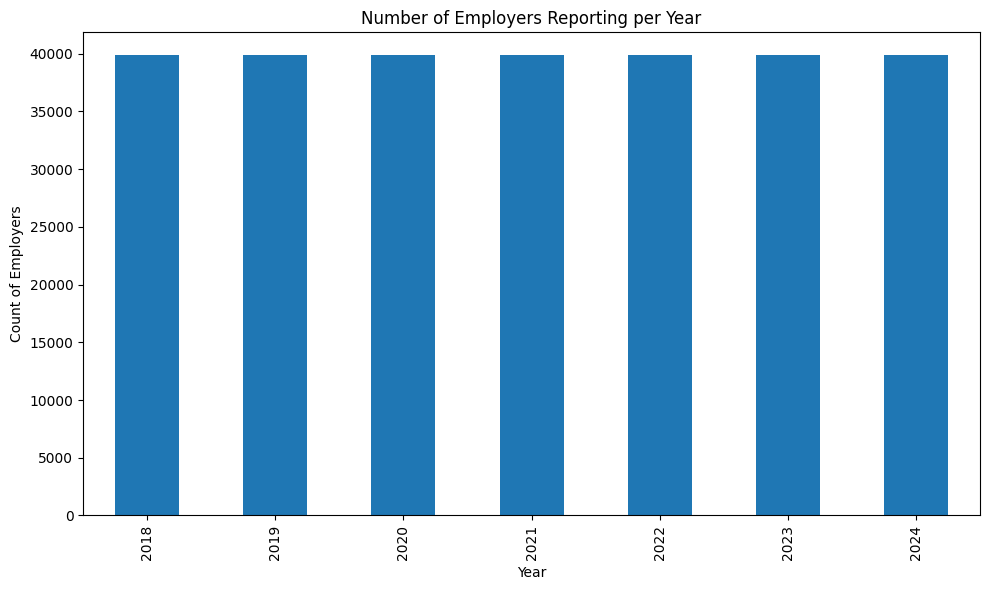

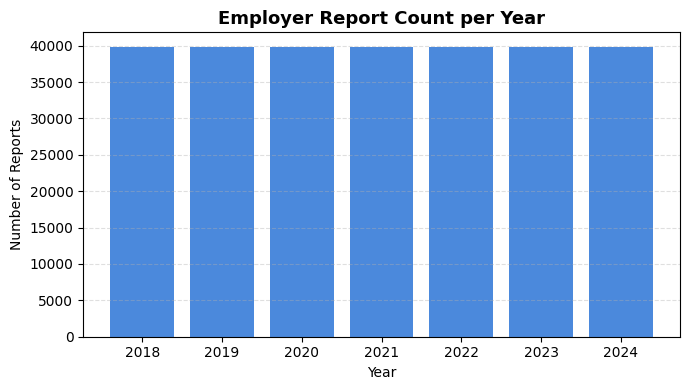

In [8]:
#Employer count per year
records_per_year = (
    long_df.groupby("Year")["EmployerId"]
    .nunique()
    .rename("EmployerCount")
)

print("\n=== Employer count per year ===")
print(records_per_year)

plt.figure()
records_per_year.plot(kind="bar")
plt.title("Number of Employers Reporting per Year")
plt.ylabel("Count of Employers")
plt.xlabel("Year")
plt.ylim(0)  # y-axis starts at 0
plt.tight_layout()
plt.show()

#for presentation
plt.figure(figsize=(7,4))
plt.bar(records_per_year.index.astype(str), records_per_year.values, color="#4B89DC")
plt.title("Employer Report Count per Year", fontsize=13, weight="bold")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

**Component Score Trends Over Time**


=== Score_WageGap trend ===
Year
2018    35.838678
2019    34.625929
2020    34.880231
2021    35.032307
2022    35.374525
2023    35.672223
2024    35.815289
Name: Score_WageGap, dtype: float64


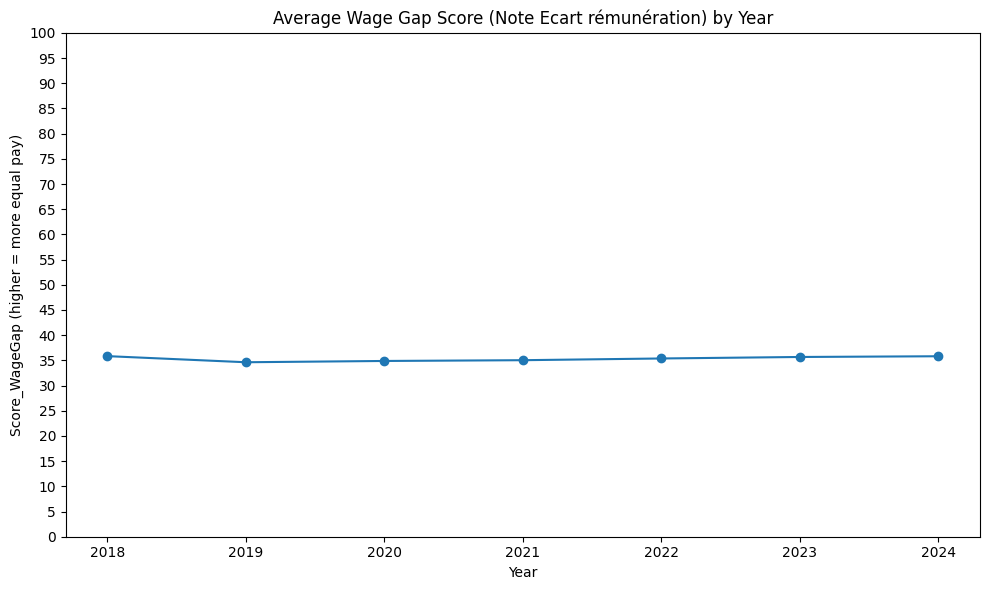


=== Score_PromotionGap trend ===
Year
2018    13.417307
2019    13.593177
2020    13.753957
2021    13.770728
2022    13.800329
2023    13.907806
2024    13.958631
Name: Score_PromotionGap, dtype: float64


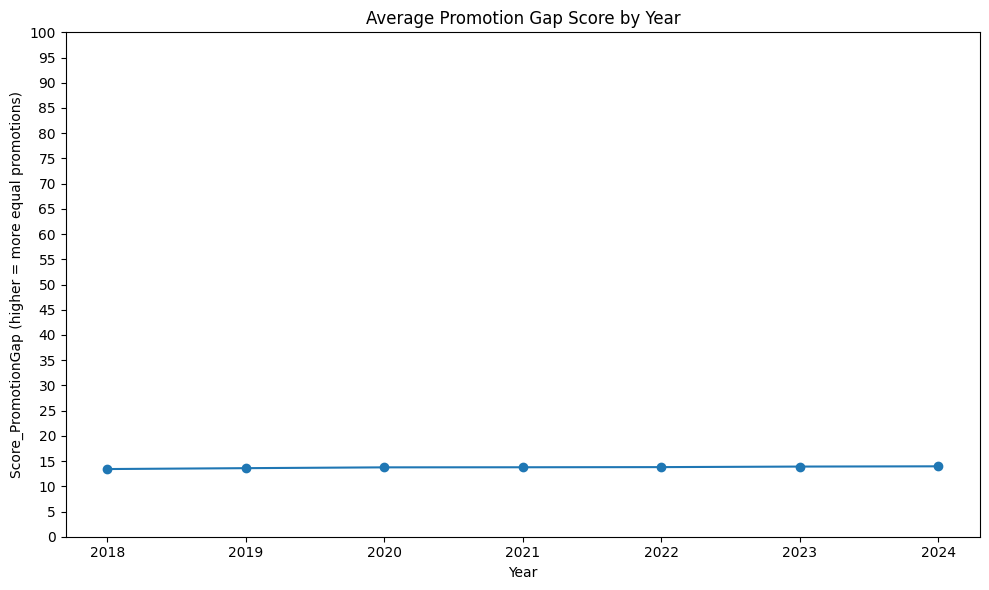


=== Score_RaiseGap trend ===
Year
2018    31.027944
2019    31.850085
2020    32.403173
2021    32.381557
2022    32.654698
2023    32.692087
2024    32.734212
Name: Score_RaiseGap, dtype: float64


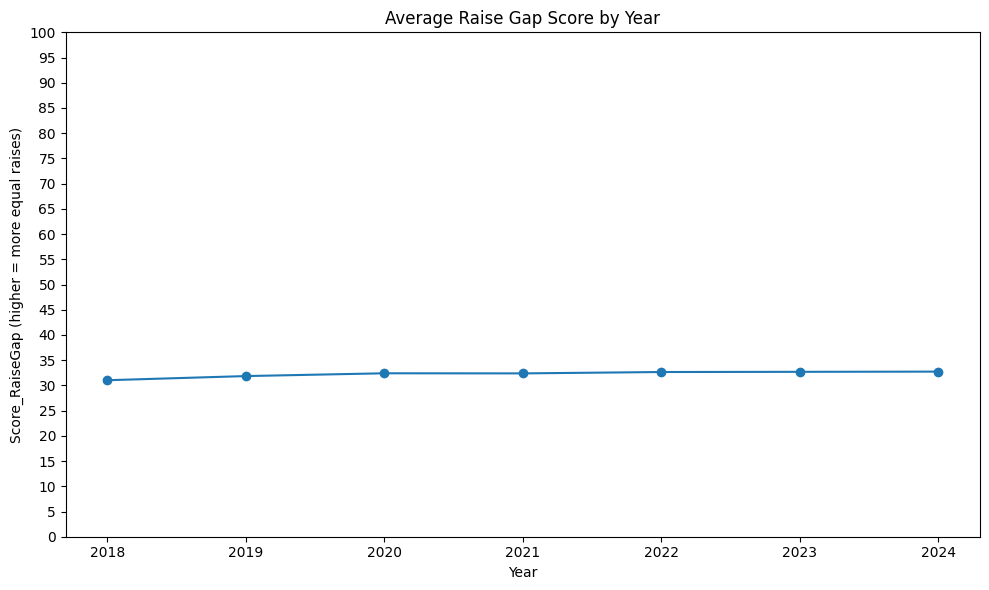


=== Score_MaternityReturn trend ===
Year
2018    10.889478
2019    11.114000
2020    11.153580
2021    11.983498
2022    13.402110
2023    13.319048
2024    13.126659
Name: Score_MaternityReturn, dtype: float64


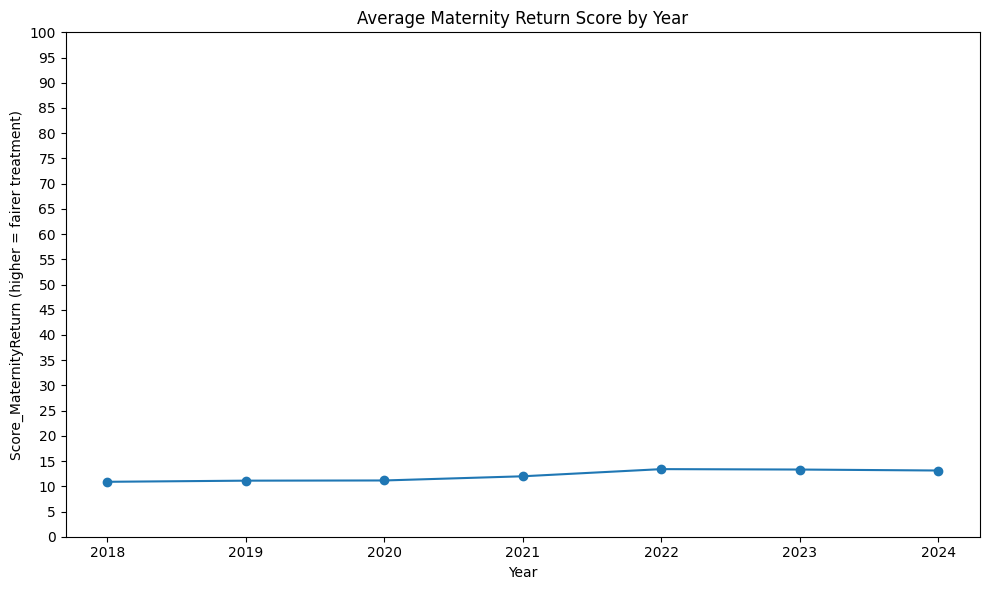


=== Score_HighEarners trend ===
Year
2018    4.092042
2019    4.446379
2020    4.484659
2021    4.594953
2022    4.715567
2023    4.800267
2024    4.899623
Name: Score_HighEarners, dtype: float64


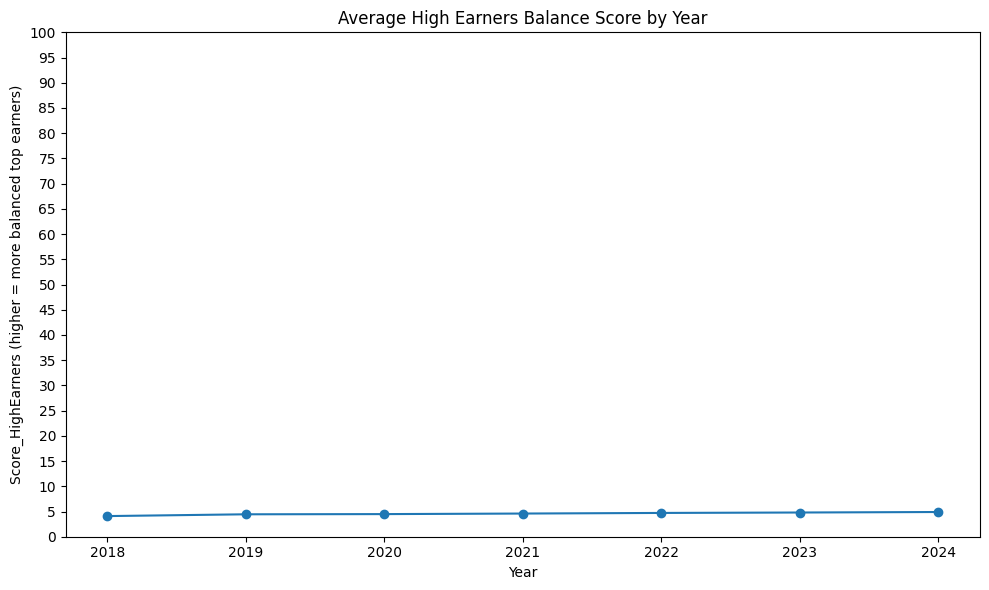


=== CompositeIndex trend ===
Year
2018    82.406437
2019    83.937065
2020    84.957213
2021    85.896849
2022    87.511429
2023    88.041043
2024    88.266350
Name: CompositeIndex, dtype: float64


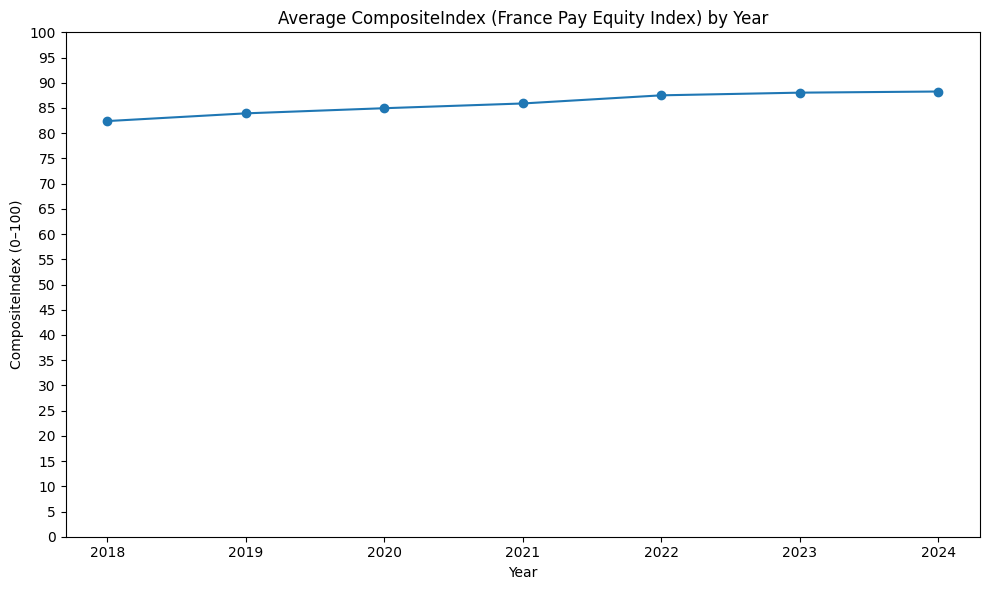

In [9]:
# Helper to plot a trend for any score column
def plot_trend(col, title, ylabel):
    series = long_df.groupby("Year")[col].mean()
    print(f"\n=== {col} trend ===")
    print(series)

    plt.figure()
    series.plot(marker="o")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)

    # Set y-axis from 0 to 50 with tick spacing
    plt.ylim(0, 50)
    plt.yticks(range(0, 101, 5))  # ticks every 5 points

    plt.tight_layout()
    plt.show()

# Plot calls remain unchanged
plot_trend("Score_WageGap",
           "Average Wage Gap Score (Note Ecart rémunération) by Year",
           "Score_WageGap (higher = more equal pay)")

plot_trend("Score_PromotionGap",
           "Average Promotion Gap Score by Year",
           "Score_PromotionGap (higher = more equal promotions)")

plot_trend("Score_RaiseGap",
           "Average Raise Gap Score by Year",
           "Score_RaiseGap (higher = more equal raises)")

plot_trend("Score_MaternityReturn",
           "Average Maternity Return Score by Year",
           "Score_MaternityReturn (higher = fairer treatment)")

plot_trend("Score_HighEarners",
           "Average High Earners Balance Score by Year",
           "Score_HighEarners (higher = more balanced top earners)")

plot_trend("CompositeIndex",
           "Average CompositeIndex (France Pay Equity Index) by Year",
           "CompositeIndex (0–100)")




=== Score_WageGap trend ===
Year
2018    35.838678
2019    34.625929
2020    34.880231
2021    35.032307
2022    35.374525
2023    35.672223
2024    35.815289
Name: Score_WageGap, dtype: float64


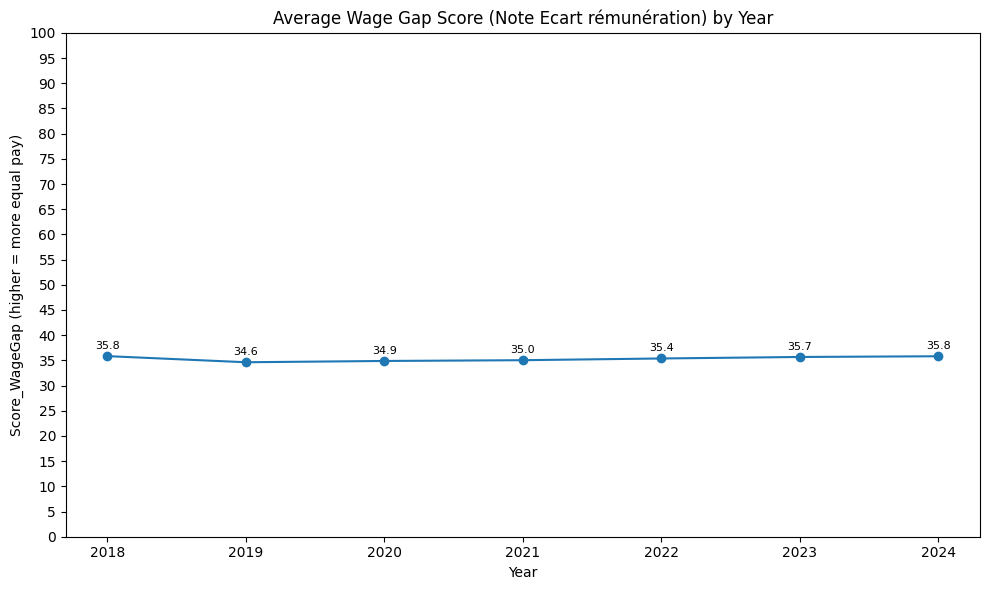


=== Score_PromotionGap trend ===
Year
2018    13.417307
2019    13.593177
2020    13.753957
2021    13.770728
2022    13.800329
2023    13.907806
2024    13.958631
Name: Score_PromotionGap, dtype: float64


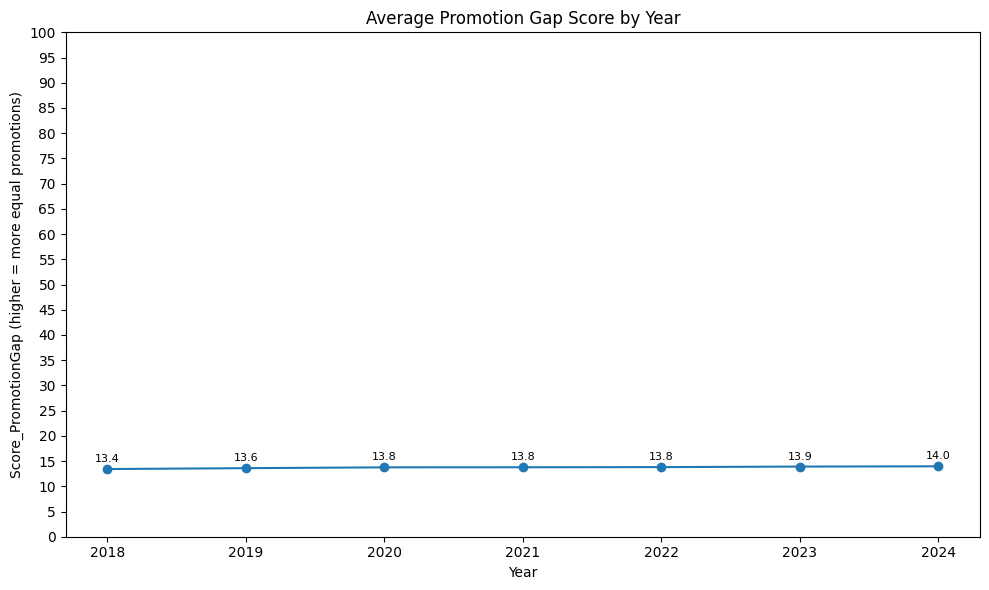


=== Score_RaiseGap trend ===
Year
2018    31.027944
2019    31.850085
2020    32.403173
2021    32.381557
2022    32.654698
2023    32.692087
2024    32.734212
Name: Score_RaiseGap, dtype: float64


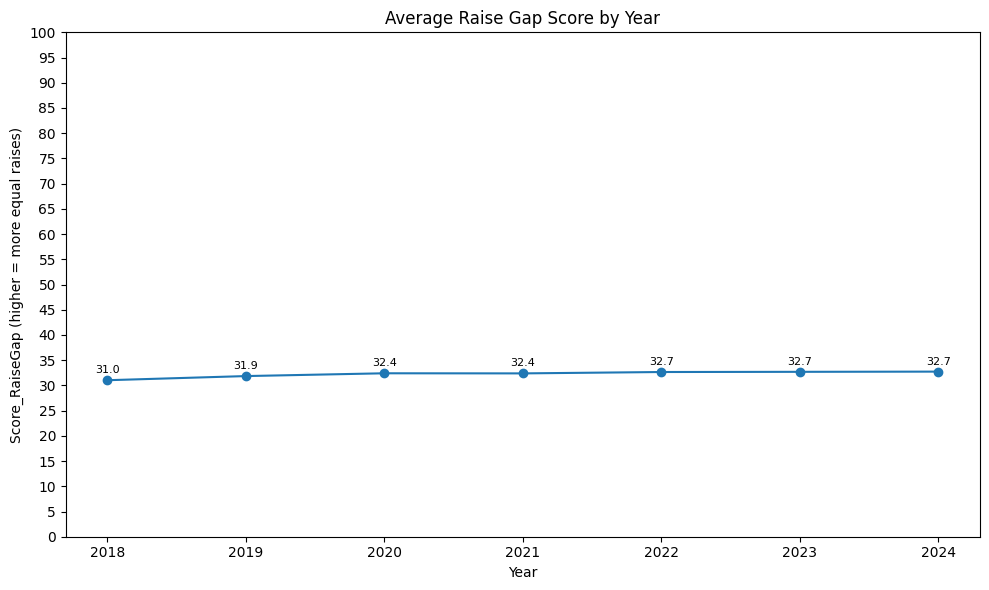


=== Score_MaternityReturn trend ===
Year
2018    10.889478
2019    11.114000
2020    11.153580
2021    11.983498
2022    13.402110
2023    13.319048
2024    13.126659
Name: Score_MaternityReturn, dtype: float64


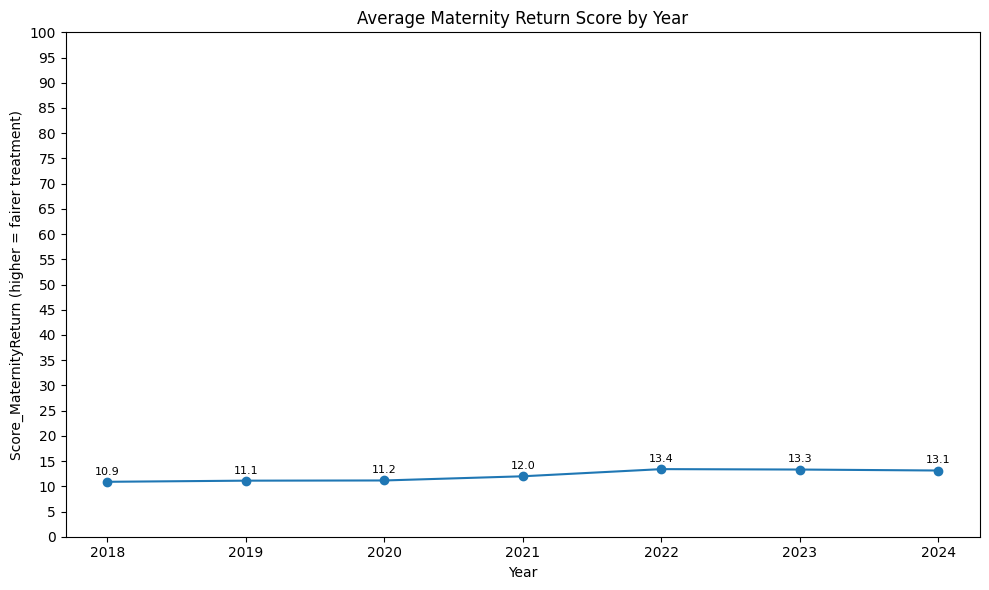


=== Score_HighEarners trend ===
Year
2018    4.092042
2019    4.446379
2020    4.484659
2021    4.594953
2022    4.715567
2023    4.800267
2024    4.899623
Name: Score_HighEarners, dtype: float64


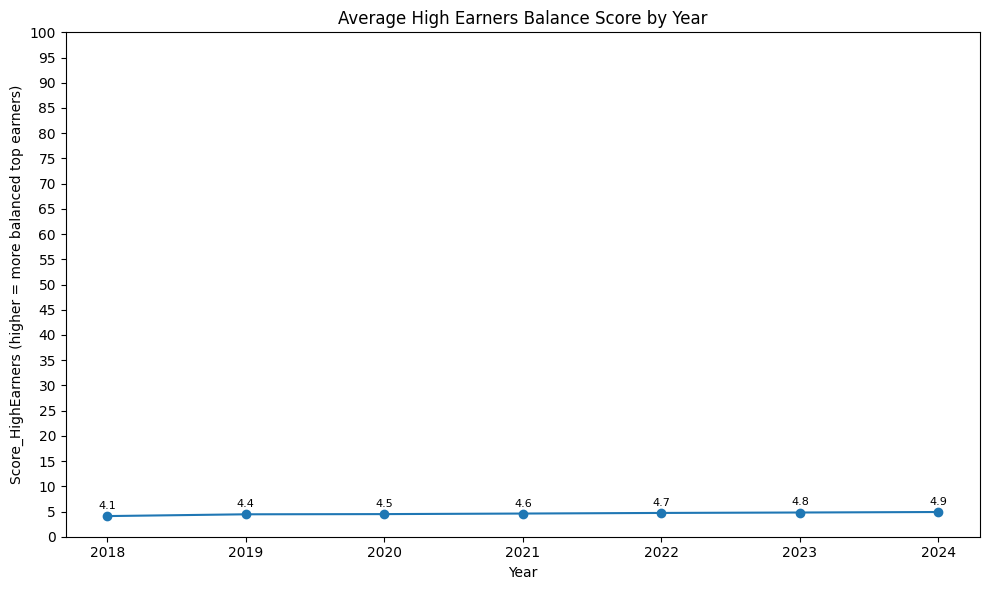


=== CompositeIndex trend ===
Year
2018    82.406437
2019    83.937065
2020    84.957213
2021    85.896849
2022    87.511429
2023    88.041043
2024    88.266350
Name: CompositeIndex, dtype: float64


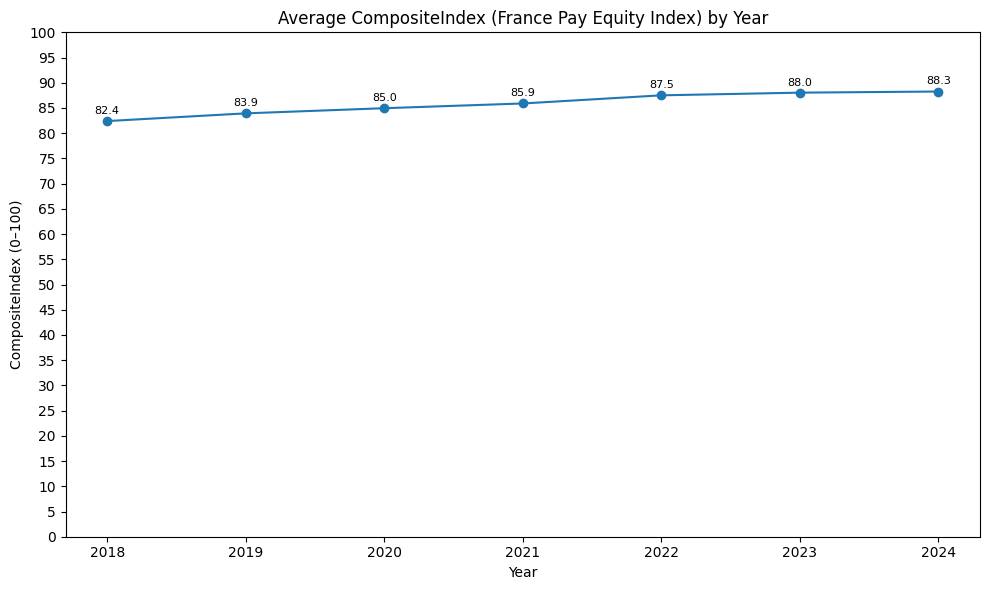

In [11]:
import matplotlib.pyplot as plt

# Helper to plot a trend for any score column
def plot_trend(col, title, ylabel):
    series = long_df.groupby("Year")[col].mean()
    print(f"\n=== {col} trend ===")
    print(series)

    years = series.index.astype(str)
    values = series.values

    plt.figure()
    plt.plot(years, values, marker="o")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)

    # Set y-axis from 0 to 50 with tick spacing every 5
    plt.ylim(0, 50)
    plt.yticks(range(0, 101, 5))

    # Add labels above every point
    for x, y in zip(years, values):
        plt.text(
            x,
            y + 1,          # small vertical offset
            f"{y:.1f}",     # value with 1 decimal
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()


# Plot calls
plot_trend(
    "Score_WageGap",
    "Average Wage Gap Score (Note Ecart rémunération) by Year",
    "Score_WageGap (higher = more equal pay)"
)

plot_trend(
    "Score_PromotionGap",
    "Average Promotion Gap Score by Year",
    "Score_PromotionGap (higher = more equal promotions)"
)

plot_trend(
    "Score_RaiseGap",
    "Average Raise Gap Score by Year",
    "Score_RaiseGap (higher = more equal raises)"
)

plot_trend(
    "Score_MaternityReturn",
    "Average Maternity Return Score by Year",
    "Score_MaternityReturn (higher = fairer treatment)"
)

plot_trend(
    "Score_HighEarners",
    "Average High Earners Balance Score by Year",
    "Score_HighEarners (higher = more balanced top earners)"
)

plot_trend(
    "CompositeIndex",
    "Average CompositeIndex (France Pay Equity Index) by Year",
    "CompositeIndex (0–100)"
)



=== Score_WageGap trend ===
Year
2018    35.838678
2019    34.625929
2020    34.880231
2021    35.032307
2022    35.374525
2023    35.672223
2024    35.815289
Name: Score_WageGap, dtype: float64


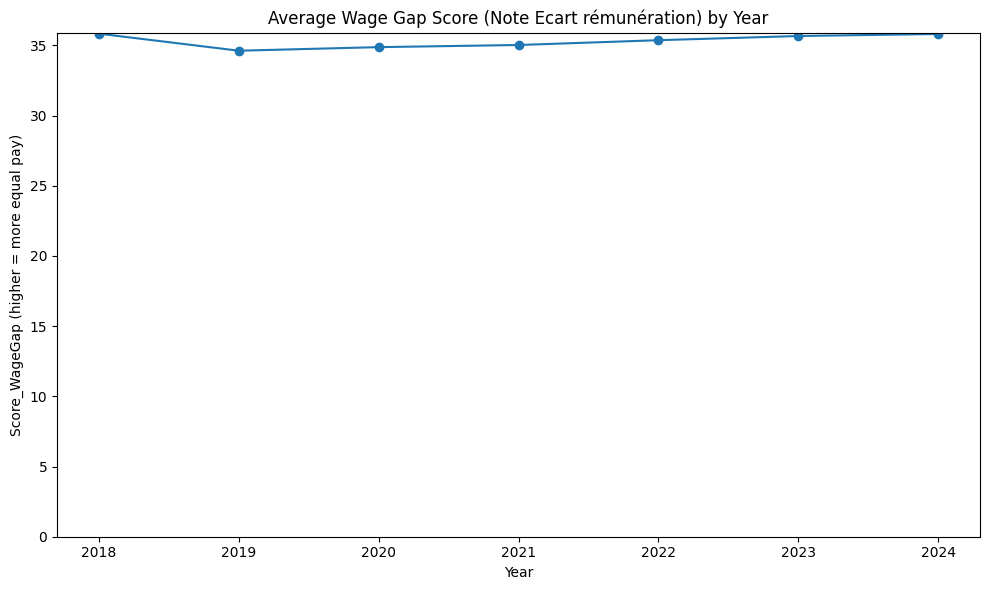


=== Score_PromotionGap trend ===
Year
2018    13.417307
2019    13.593177
2020    13.753957
2021    13.770728
2022    13.800329
2023    13.907806
2024    13.958631
Name: Score_PromotionGap, dtype: float64


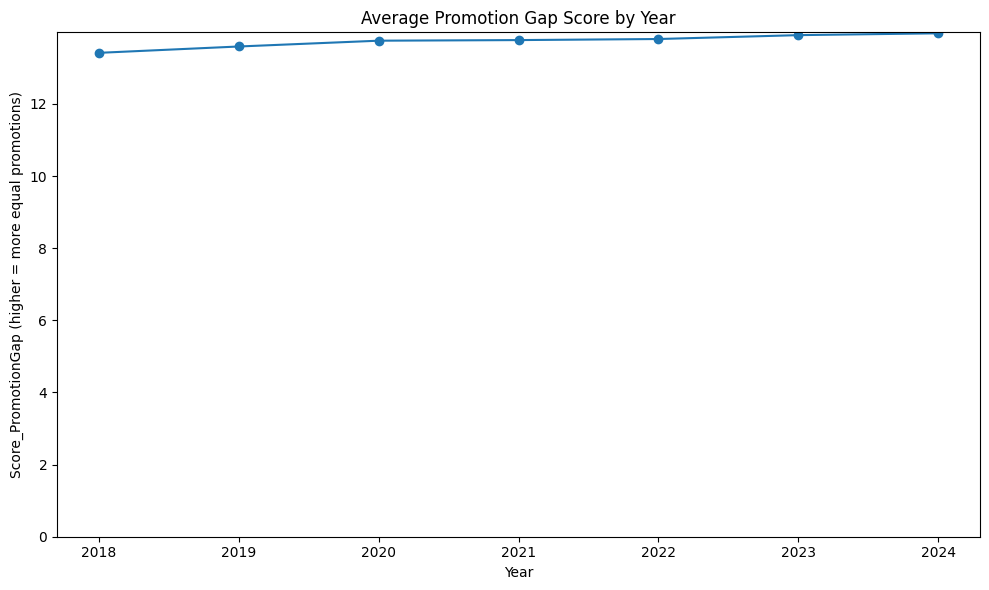


=== Score_RaiseGap trend ===
Year
2018    31.027944
2019    31.850085
2020    32.403173
2021    32.381557
2022    32.654698
2023    32.692087
2024    32.734212
Name: Score_RaiseGap, dtype: float64


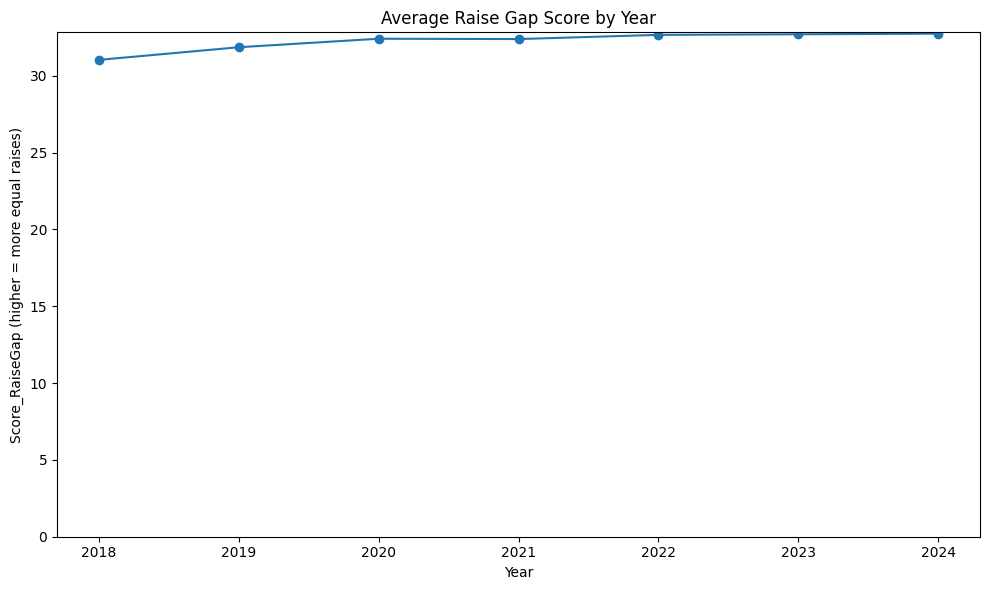


=== Score_MaternityReturn trend ===
Year
2018    10.889478
2019    11.114000
2020    11.153580
2021    11.983498
2022    13.402110
2023    13.319048
2024    13.126659
Name: Score_MaternityReturn, dtype: float64


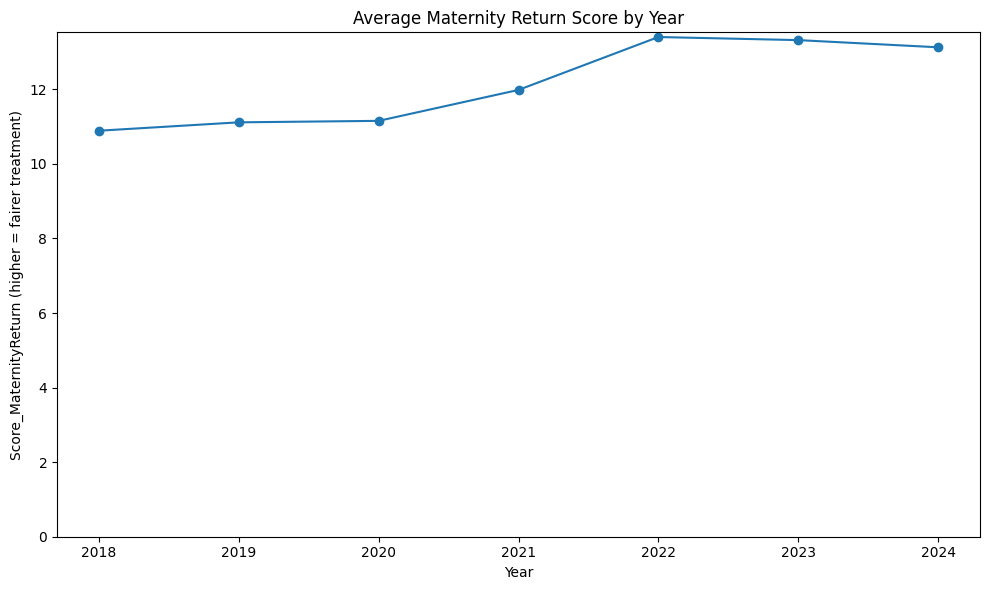


=== Score_HighEarners trend ===
Year
2018    4.092042
2019    4.446379
2020    4.484659
2021    4.594953
2022    4.715567
2023    4.800267
2024    4.899623
Name: Score_HighEarners, dtype: float64


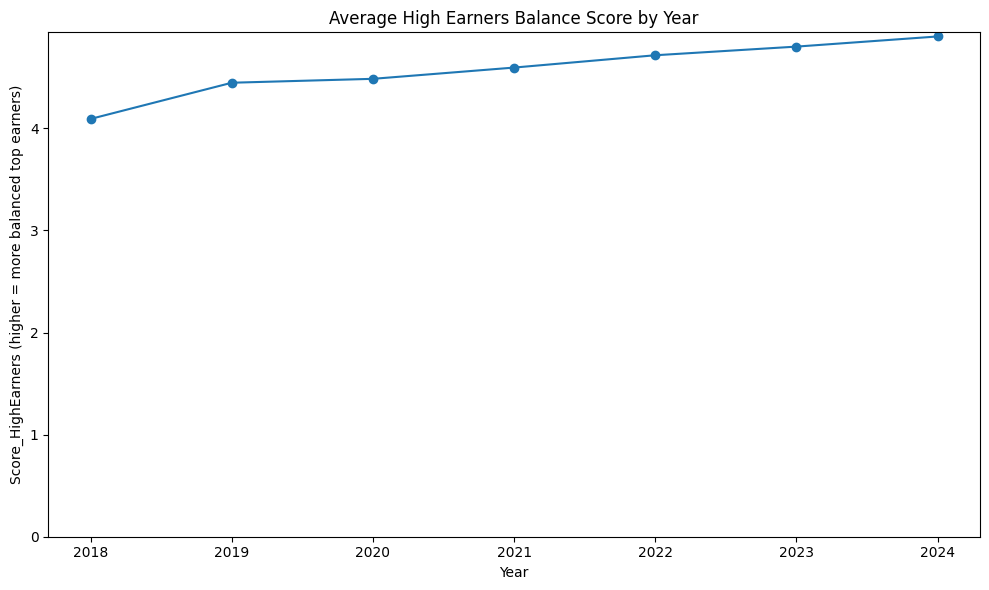


=== CompositeIndex trend ===
Year
2018    82.406437
2019    83.937065
2020    84.957213
2021    85.896849
2022    87.511429
2023    88.041043
2024    88.266350
Name: CompositeIndex, dtype: float64


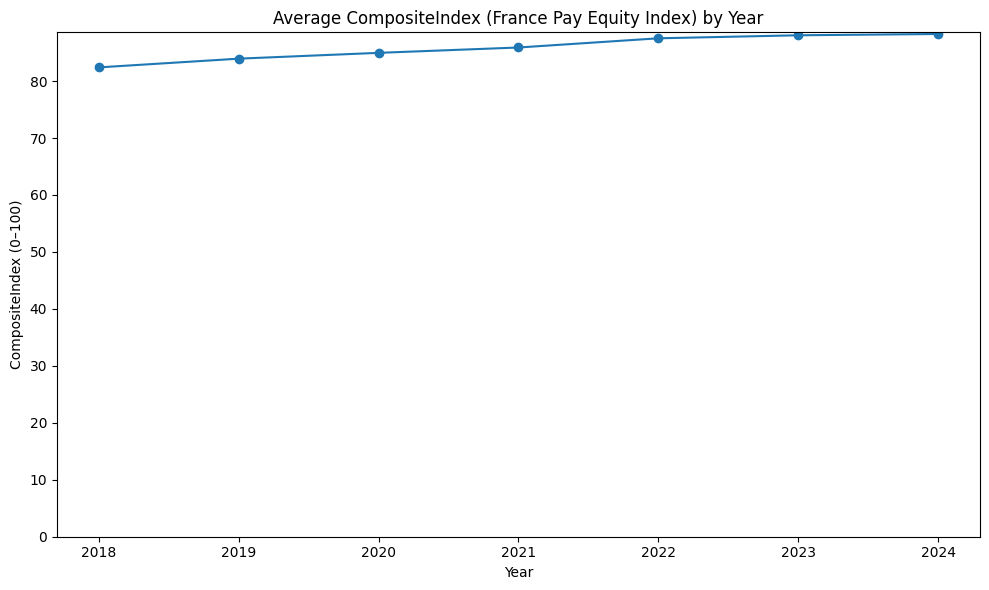

In [10]:
# Helper to plot a trend for any score column
def plot_trend(col, title, ylabel):
    series = long_df.groupby("Year")[col].mean()
    print(f"\n=== {col} trend ===")
    print(series)
    plt.figure()
    series.plot(marker="o")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

plot_trend("Score_WageGap",
           "Average Wage Gap Score (Note Ecart rémunération) by Year",
           "Score_WageGap (higher = more equal pay)")

plot_trend("Score_PromotionGap",
           "Average Promotion Gap Score by Year",
           "Score_PromotionGap (higher = more equal promotions)")

plot_trend("Score_RaiseGap",
           "Average Raise Gap Score by Year",
           "Score_RaiseGap (higher = more equal raises)")

plot_trend("Score_MaternityReturn",
           "Average Maternity Return Score by Year",
           "Score_MaternityReturn (higher = fairer treatment)")

plot_trend("Score_HighEarners",
           "Average High Earners Balance Score by Year",
           "Score_HighEarners (higher = more balanced top earners)")

plot_trend("CompositeIndex",
           "Average CompositeIndex (France Pay Equity Index) by Year",
           "CompositeIndex (0–100)")


**Distributions of Scores – Latest Year**

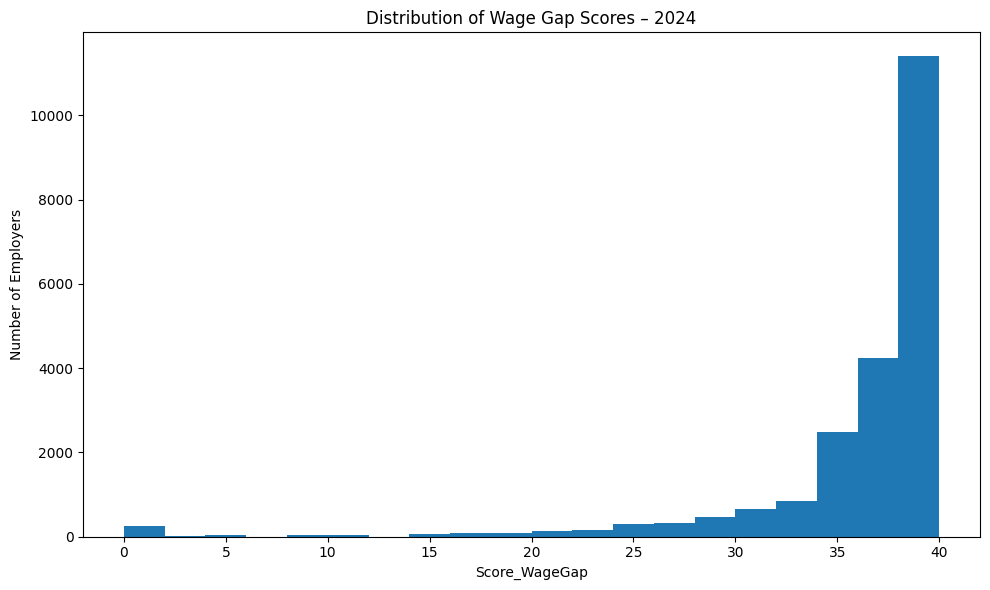

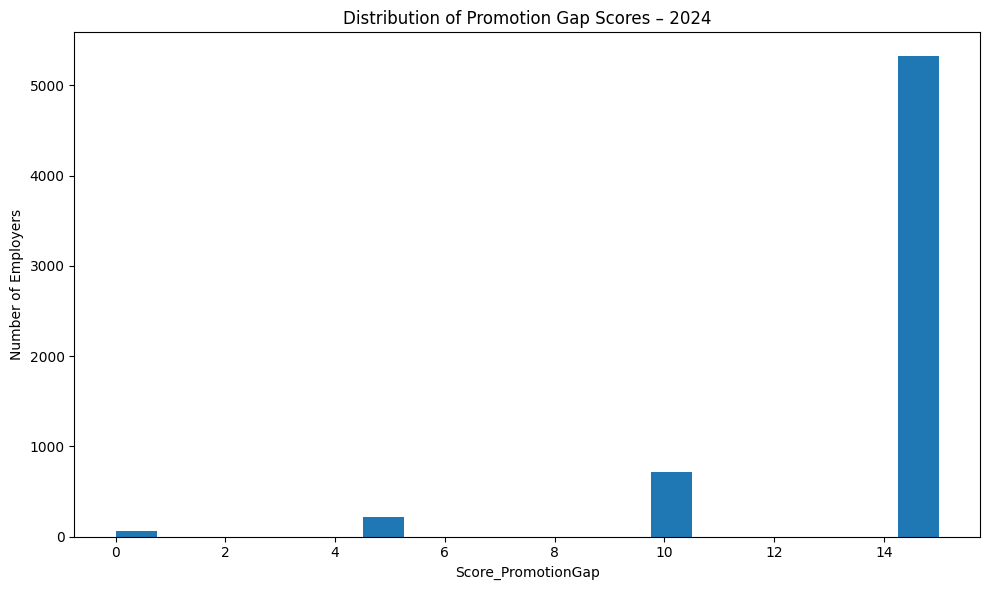

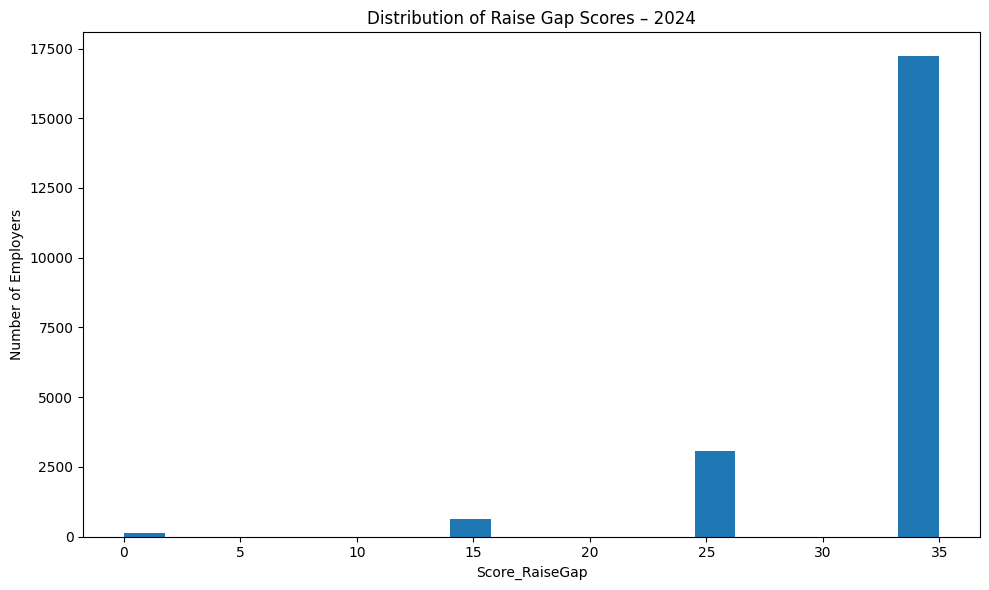

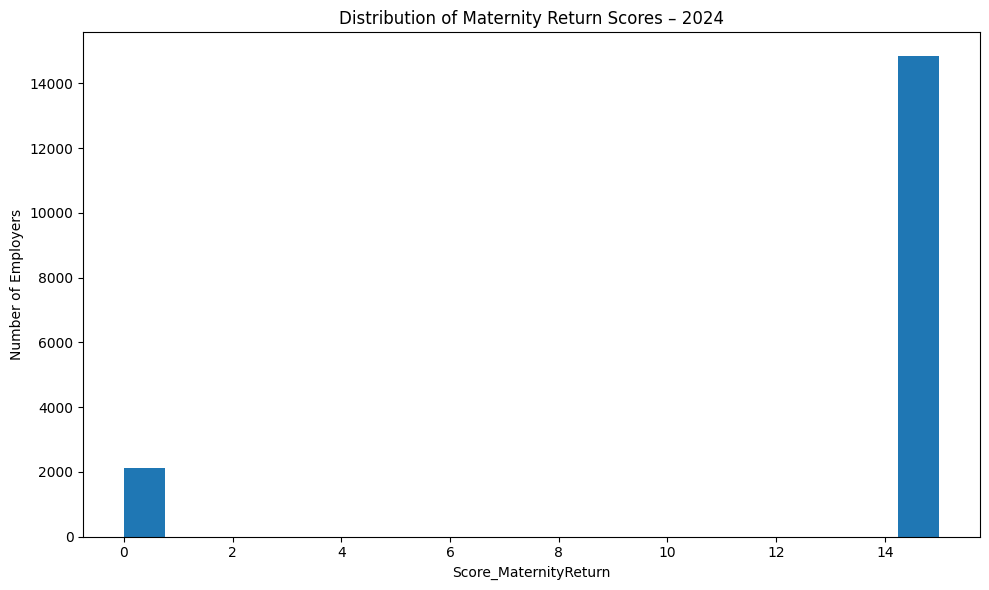

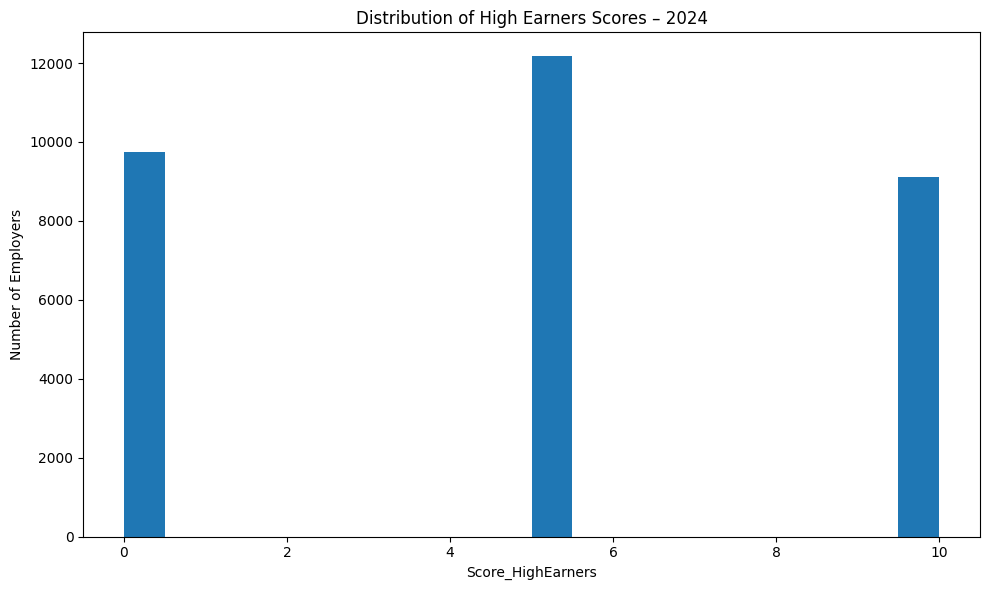

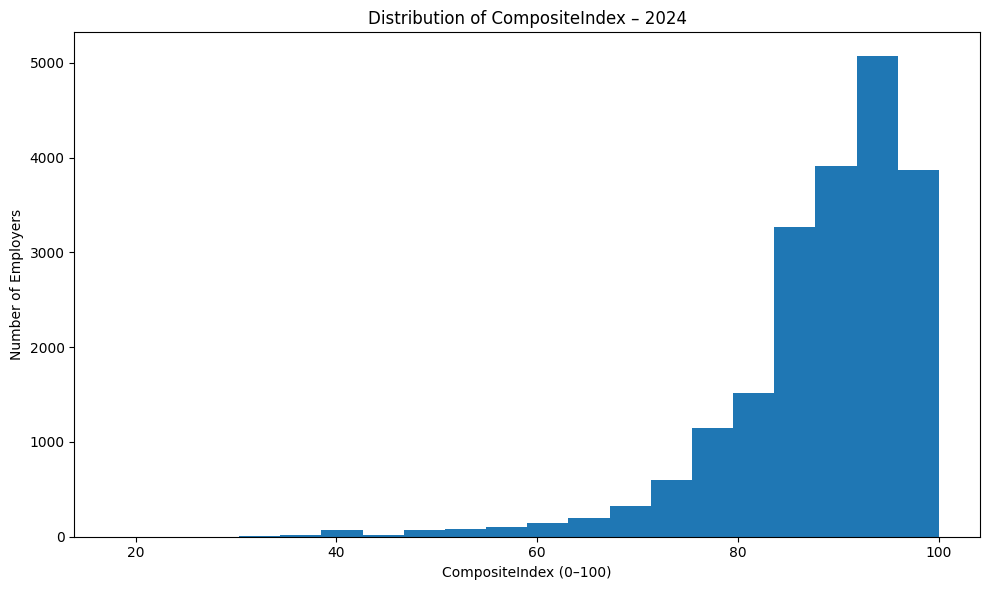

In [11]:
def plot_latest_hist(col, title, xlabel):
    series = long_df.loc[latest_mask, col].dropna()
    plt.figure()
    plt.hist(series, bins=20)
    plt.title(f"{title} – {latest_year}")
    plt.xlabel(xlabel)
    plt.ylabel("Number of Employers")
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

plot_latest_hist("Score_WageGap",
                 "Distribution of Wage Gap Scores",
                 "Score_WageGap")

plot_latest_hist("Score_PromotionGap",
                 "Distribution of Promotion Gap Scores",
                 "Score_PromotionGap")

plot_latest_hist("Score_RaiseGap",
                 "Distribution of Raise Gap Scores",
                 "Score_RaiseGap")

plot_latest_hist("Score_MaternityReturn",
                 "Distribution of Maternity Return Scores",
                 "Score_MaternityReturn")

plot_latest_hist("Score_HighEarners",
                 "Distribution of High Earners Scores",
                 "Score_HighEarners")

plot_latest_hist("CompositeIndex",
                 "Distribution of CompositeIndex",
                 "CompositeIndex (0–100)")


**Boxplots of Component Scores by Year**

/tmp/ipython-input-785999669.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data, labels=YEARS, showfliers=True)
/tmp/ipython-input-785999669.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data, labels=YEARS, showfliers=False)


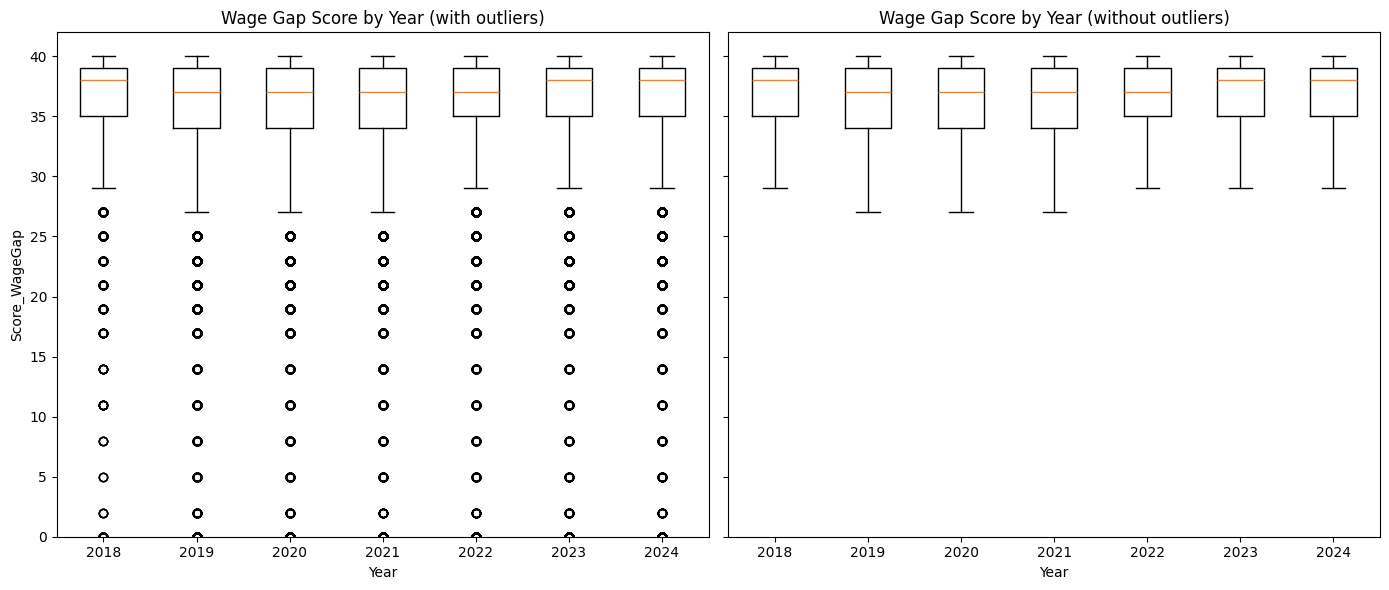

In [12]:
def boxplot_by_year(col, title_prefix):
    data = [
        long_df.loc[long_df["Year"] == y, col].dropna()
        for y in YEARS
    ]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # With outliers
    axes[0].boxplot(data, labels=YEARS, showfliers=True)
    axes[0].set_title(f"{title_prefix} (with outliers)")
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel(col)
    axes[0].set_ylim(0)

    # Without outliers
    axes[1].boxplot(data, labels=YEARS, showfliers=False)
    axes[1].set_title(f"{title_prefix} (without outliers)")
    axes[1].set_xlabel("Year")
    axes[1].set_ylim(0)

    plt.tight_layout()
    plt.show()

boxplot_by_year("Score_WageGap",
                "Wage Gap Score by Year")


**Industry Segmentation (PrimarySicCode)**


=== Average Wage Gap Score by Industry (top 15, latest year) ===
PrimarySicCode
47.11F - Hypermarchés                                               38.726527
47.11D - Supermarchés                                               38.465296
49.41B - Transports routiers de fret de proximité                   37.714286
49.41A - Transports routiers de fret interurbains                   37.696078
81.21Z - Nettoyage courant des bâtiments                            37.660269
88.99B - Action sociale sans hébergement n.c.a.                     36.876000
86.10Z - Activités hospitalières                                    36.568047
78.20Z - Activités des agences de travail temporaire                36.216216
88.10A - Aide à domicile                                            36.051163
71.12B - Ingénierie, études techniques                              35.751701
87.10A - Hébergement médicalisé pour personnes âgées                35.530303
62.02A - Conseil en systèmes et logiciels informatiques      

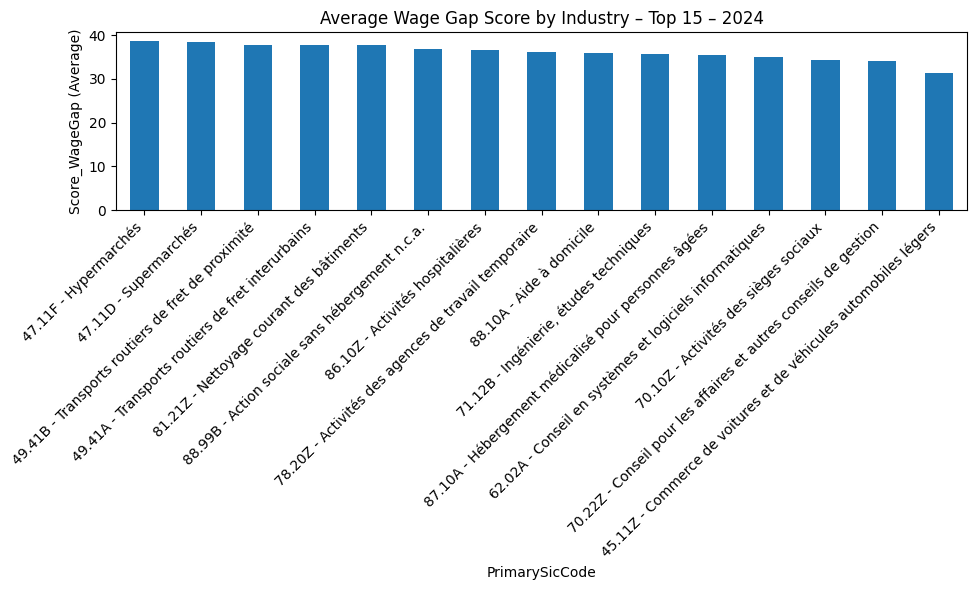

In [13]:
if "PrimarySicCode" in long_df.columns:
    latest_industry = long_df.loc[latest_mask].dropna(subset=["PrimarySicCode"])

    # Focus on top N industries by count
    N = 15
    top_inds = latest_industry["PrimarySicCode"].value_counts().head(N).index
    latest_industry_top = latest_industry[latest_industry["PrimarySicCode"].isin(top_inds)]

    # 5A. Wage gap score by industry
    ind_wage = (
        latest_industry_top
        .groupby("PrimarySicCode")["Score_WageGap"]
        .mean()
        .sort_values(ascending=False)
    )

    print("\n=== Average Wage Gap Score by Industry (top 15, latest year) ===")
    print(ind_wage)

    plt.figure()
    ind_wage.plot(kind="bar")
    plt.title(f"Average Wage Gap Score by Industry – Top {N} – {latest_year}")
    plt.xlabel("PrimarySicCode")
    plt.ylabel("Score_WageGap (Average)")
    plt.ylim(0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


=== Average CompositeIndex by Industry (top 15, latest year) ===
PrimarySicCode
47.11D - Supermarchés                                               93.432361
47.11F - Hypermarchés                                               92.634489
81.21Z - Nettoyage courant des bâtiments                            91.553846
86.10Z - Activités hospitalières                                    91.138829
87.10A - Hébergement médicalisé pour personnes âgées                90.252632
88.99B - Action sociale sans hébergement n.c.a.                     89.905473
78.20Z - Activités des agences de travail temporaire                89.636364
49.41A - Transports routiers de fret interurbains                   87.181818
49.41B - Transports routiers de fret de proximité                   87.000000
70.10Z - Activités des sièges sociaux                               86.847973
71.12B - Ingénierie, études techniques                              86.511149
70.22Z - Conseil pour les affaires et autres conseils de gest

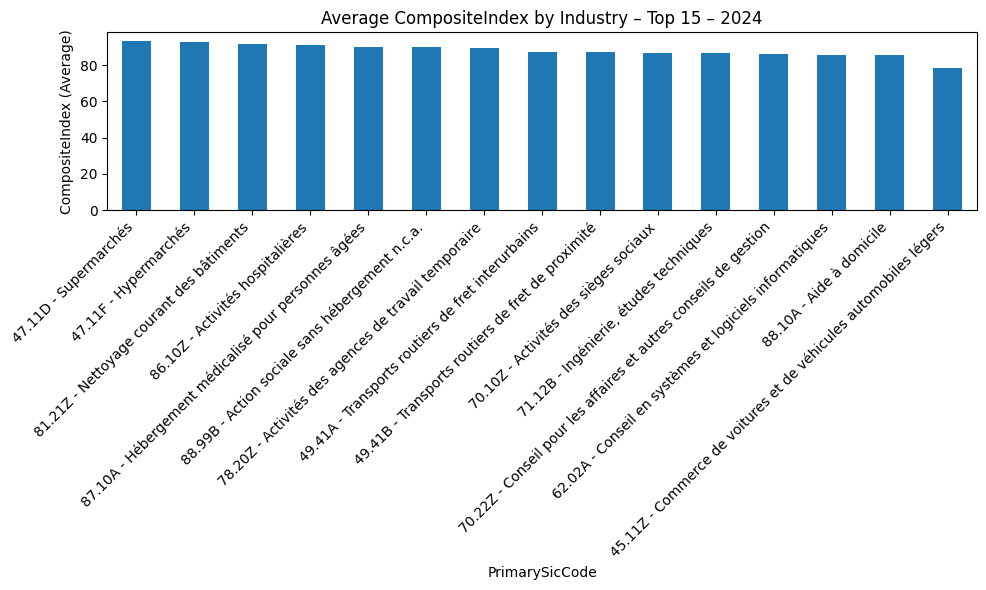

In [14]:
# 5B. CompositeIndex by industry
ind_ci = (
    latest_industry_top
    .groupby("PrimarySicCode")["CompositeIndex"]
    .mean()
    .sort_values(ascending=False)
)

print("\n=== Average CompositeIndex by Industry (top 15, latest year) ===")
print(ind_ci)

plt.figure()
ind_ci.plot(kind="bar")
plt.title(f"Average CompositeIndex by Industry – Top {N} – {latest_year}")
plt.xlabel("PrimarySicCode")
plt.ylabel("CompositeIndex (Average)")
plt.ylim(0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Employer Size Segmentation**


=== Average scores by EmployerSize (latest year) ===
              Score_WageGap  Score_PromotionGap  Score_RaiseGap  \
EmployerSize                                                      
1000 et plus      37.716461           14.476401             NaN   
251 à 999         36.827632           13.816879             NaN   
50 à 250          35.287722                 NaN       32.734212   

              Score_HighEarners  CompositeIndex  
EmployerSize                                     
1000 et plus           4.638205       90.587021  
251 à 999              5.034722       88.614852  
50 à 250               4.883087       87.922712  


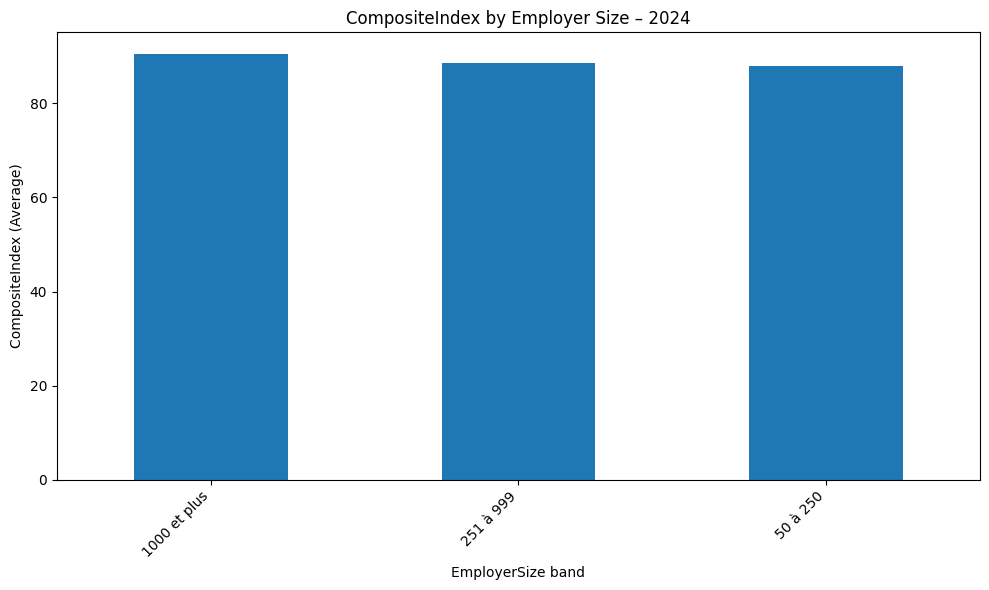

In [15]:
size_cols = ["Score_WageGap", "Score_PromotionGap",
             "Score_RaiseGap", "Score_HighEarners", "CompositeIndex"]

latest_size = long_df.loc[latest_mask].dropna(subset=["EmployerSize"])

size_scores = (
    latest_size.groupby("EmployerSize")[size_cols]
    .mean()
)

print("\n=== Average scores by EmployerSize (latest year) ===")
print(size_scores)

plt.figure(figsize=(10, 6))
size_scores["CompositeIndex"].sort_values(ascending=False).plot(kind="bar")
plt.title(f"CompositeIndex by Employer Size – {latest_year}")
plt.xlabel("EmployerSize band")
plt.ylabel("CompositeIndex (Average)")
plt.ylim(0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**TrendCategory (Improving / Declining / Stable)**


=== TrendBucket distribution (company level, overall) ===
TrendCategory
Declined             0.115414
Improved             0.271607
Insufficient Data    0.406470
Stable               0.206510
Name: proportion, dtype: float64


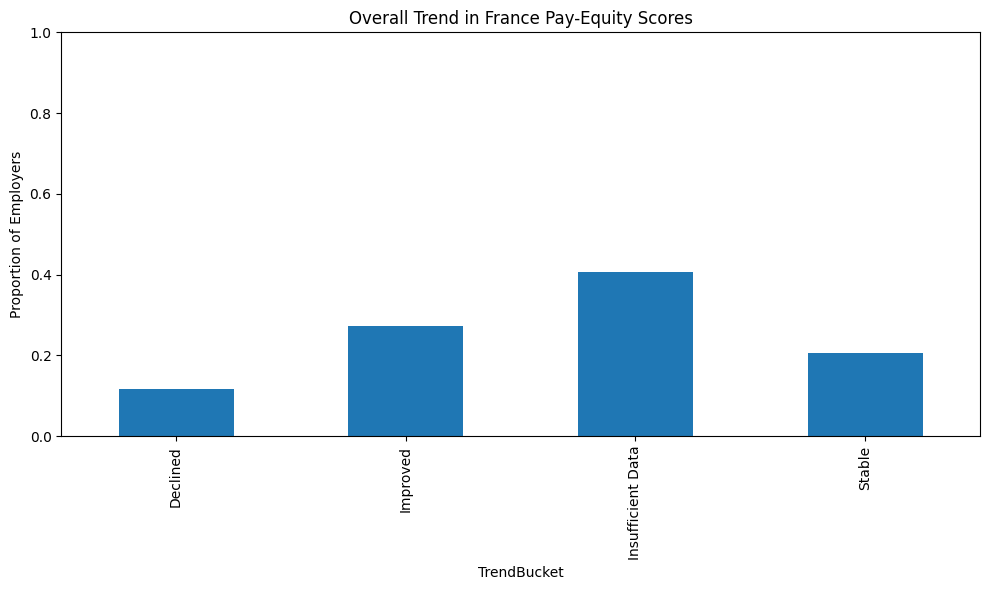

In [16]:
import numpy as np
import re

# Work at company level (original df)
trend_raw = df["TrendCategory"].astype(str).fillna("Insufficient Data")

# 1) Bucket into Improved / Declined / Stable / Insufficient Data
def bucket_trend(s):
    s = s.strip()
    if s.startswith("Improved"):
        return "Improved"
    if s.startswith("Declined"):
        return "Declined"
    if s.startswith("Stable"):
        return "Stable"
    if s == "Insufficient Data":
        return "Insufficient Data"
    return "Other/Unknown"

trend_bucket = trend_raw.apply(bucket_trend)

# 2) Optional: extract numeric change (e.g. "+23" or "-15")
change_num = (
    trend_raw.str.extract(r"([+-]?\d+)", expand=False)
             .astype(float)
)

df["TrendBucket"] = trend_bucket
df["TrendChange"] = change_num

# SIMPLE DISTRIBUTION PLOT
dist = trend_bucket.value_counts(normalize=True).sort_index()
print("\n=== TrendBucket distribution (company level, overall) ===")
print(dist)

plt.figure()
dist.plot(kind="bar")
plt.title("Overall Trend in France Pay-Equity Scores")
plt.ylabel("Proportion of Employers")
plt.xlabel("TrendBucket")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


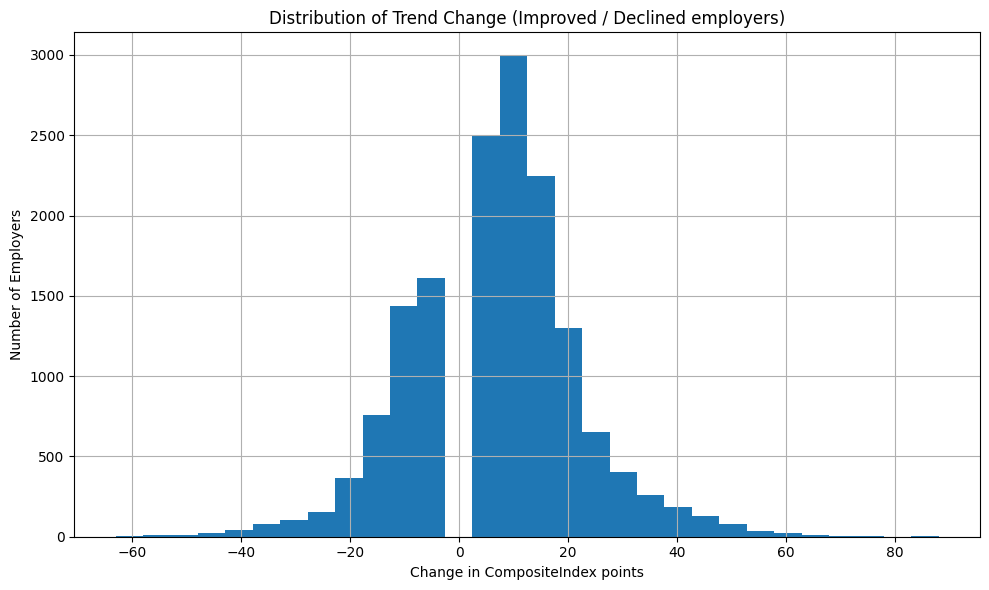

In [17]:
mask_id = df["TrendBucket"].isin(["Improved", "Declined"])
plt.figure()
df.loc[mask_id, "TrendChange"].hist(bins=30)
plt.title("Distribution of Trend Change (Improved / Declined employers)")
plt.xlabel("Change in CompositeIndex points")
plt.ylabel("Number of Employers")
plt.ylim(0)
plt.tight_layout()
plt.show()



=== CompositeIndex by TrendBucket ===
TrendBucket
Declined             79.594571
Improved             91.287723
Insufficient Data    84.129751
Stable               89.643132
Name: CompositeIndex, dtype: float64


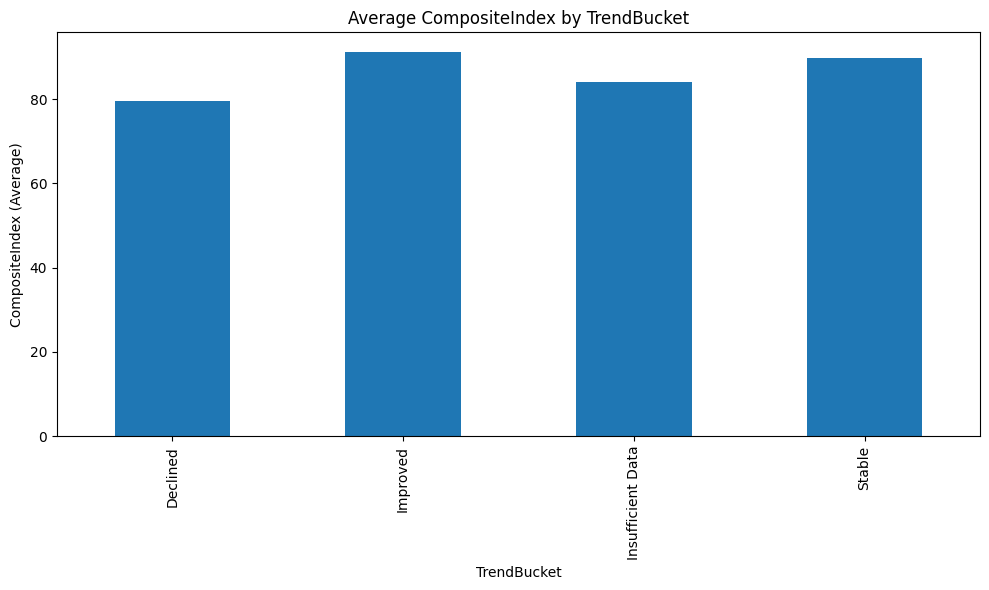

In [18]:
# Use latest-year CompositeIndex from long_df (company-level, latest year)
latest_ci = (
    long_df[long_df["Year"] == latest_year]
      .groupby("EmployerId")["CompositeIndex"].mean()
)

tmp = df[["EmployerId", "TrendBucket"]].set_index("EmployerId").join(latest_ci)
ci_by_bucket = tmp.groupby("TrendBucket")["CompositeIndex"].mean()

print("\n=== CompositeIndex by TrendBucket ===")
print(ci_by_bucket)

plt.figure()
ci_by_bucket.plot(kind="bar")
plt.title("Average CompositeIndex by TrendBucket")
plt.xlabel("TrendBucket")
plt.ylabel("CompositeIndex (Average)")
plt.ylim(0)
plt.tight_layout()
plt.show()


In [19]:
import re
import numpy as np

# Work at company level
trend_raw = df["TrendCategory"].astype(str).fillna("Insufficient Data")

def bucket_trend(s):
    s = s.strip()
    if s.startswith("Improved"):
        return "Improved"
    if s.startswith("Declined"):
        return "Declined"
    if s.startswith("Stable"):
        return "Stable"
    if s == "Insufficient Data":
        return "Insufficient Data"
    return "Other/Unknown"

# Bucket + numeric change
df["TrendBucket"] = trend_raw.apply(bucket_trend)
df["TrendChange"] = (
    trend_raw.str.extract(r"([+-]?\d+)", expand=False)
             .astype(float)
)



=== Average CompositeIndex by TrendBucket – 2024 ===
TrendBucket
Declined             79.594571
Improved             91.287723
Insufficient Data    84.129751
Stable               89.643132
Name: CompositeIndex, dtype: float64


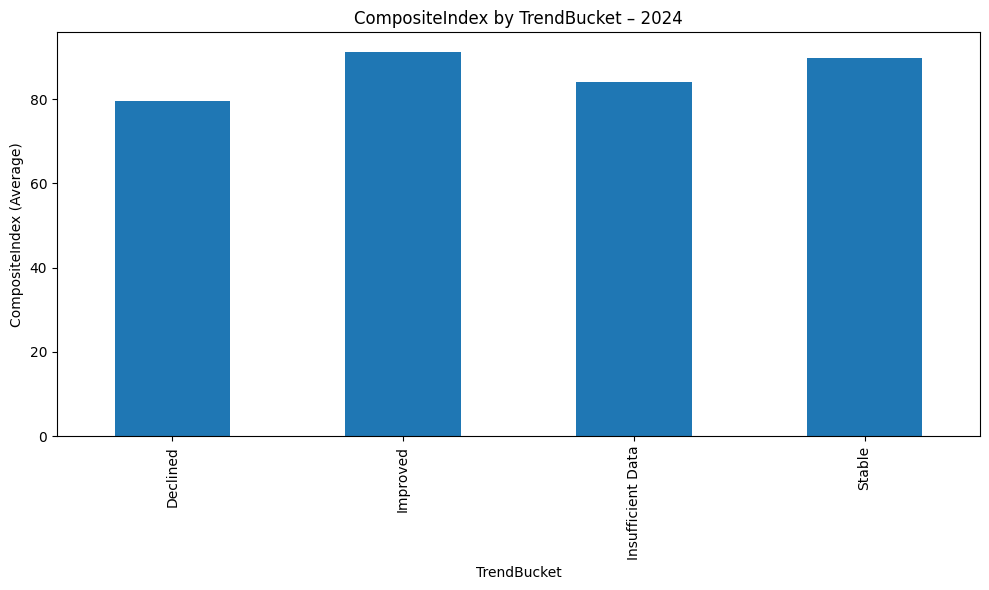

In [20]:
# 7B. CompositeIndex by TrendBucket (latest year, CLEAN VERSION)

# latest-year CompositeIndex at company level
latest_ci_company = (
    long_df[long_df["Year"] == latest_year]
      .groupby("EmployerId")["CompositeIndex"]
      .mean()
)

# join with TrendBucket
trend_ci = (
    df[["EmployerId", "TrendBucket"]]
      .set_index("EmployerId")
      .join(latest_ci_company)
      .dropna(subset=["CompositeIndex", "TrendBucket"])
)

ci_by_bucket = (
    trend_ci.groupby("TrendBucket")["CompositeIndex"]
    .mean()
    .sort_index()
)

print(f"\n=== Average CompositeIndex by TrendBucket – {latest_year} ===")
print(ci_by_bucket)

plt.figure()
ci_by_bucket.plot(kind="bar")
plt.title(f"CompositeIndex by TrendBucket – {latest_year}")
plt.xlabel("TrendBucket")
plt.ylabel("CompositeIndex (Average)")
plt.ylim(0)   # y-axis starts at 0
plt.tight_layout()
plt.show()


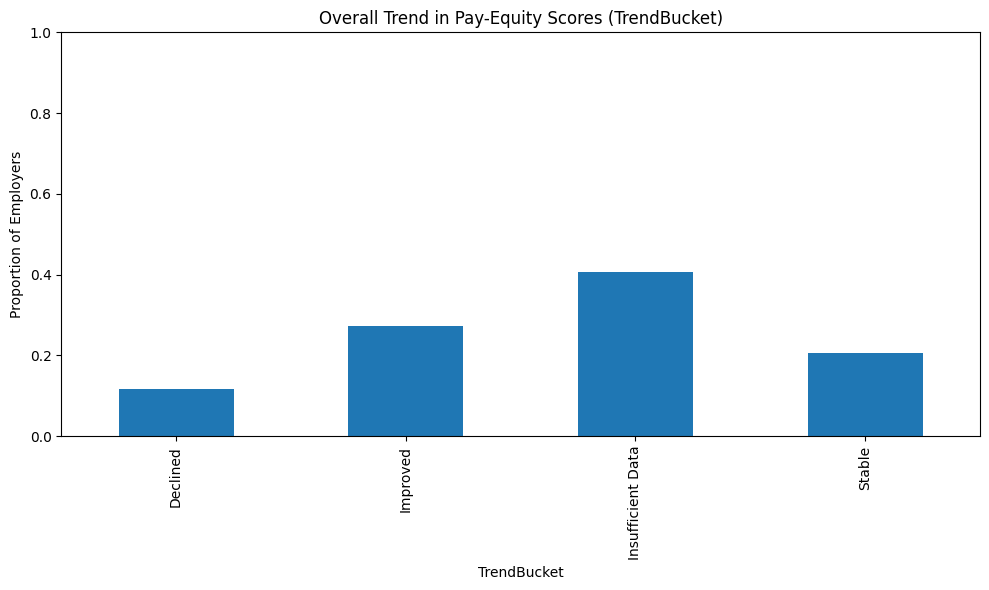

In [21]:
dist = df["TrendBucket"].value_counts(normalize=True).sort_index()

plt.figure()
dist.plot(kind="bar")
plt.title("Overall Trend in Pay-Equity Scores (TrendBucket)")
plt.xlabel("TrendBucket")
plt.ylabel("Proportion of Employers")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



=== Average component scores by TrendBucket – 2024 ===
                   Score_WageGap  Score_PromotionGap  Score_RaiseGap  \
TrendBucket                                                            
Improved               36.670706           14.364234       34.067366   
Stable                 36.524959           13.974045       33.769422   
Insufficient Data      33.467668           12.458333       31.936508   
Declined               33.723081           12.799760       30.159370   

                   Score_MaternityReturn  Score_HighEarners  CompositeIndex  
TrendBucket                                                                  
Improved                       14.539946           6.065420       91.287723  
Stable                         14.071598           5.417132       89.643132  
Insufficient Data              10.347372           3.412668       84.129751  
Declined                       11.112747           5.061920       79.594571  


<Figure size 1000x600 with 0 Axes>

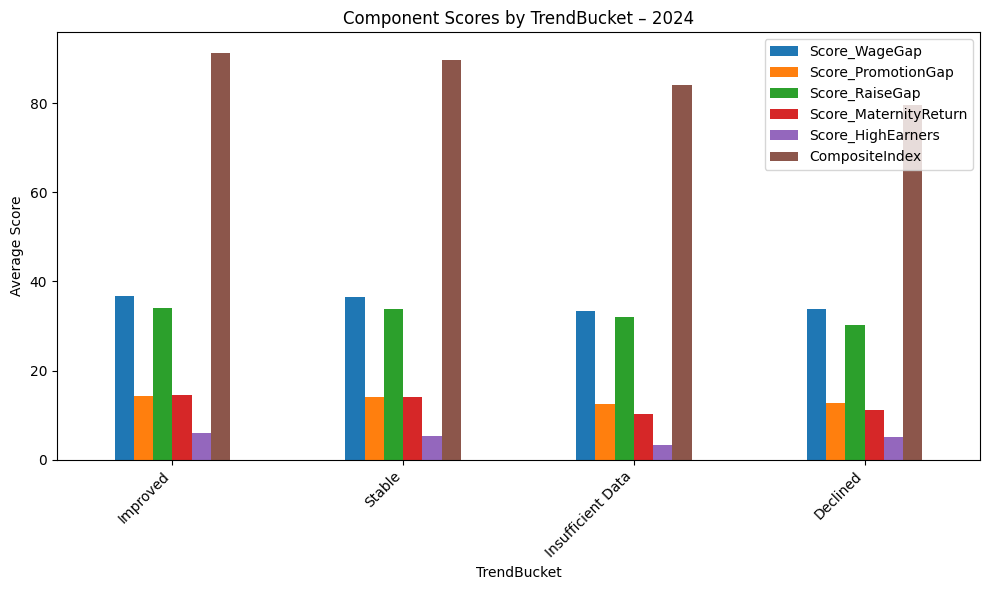

In [22]:
# 7C. Component scores by TrendCategory (latest year)

# Prepare latest_trend by merging latest year's long_df data with TrendBucket from df
latest_trend = (
    long_df[long_df["Year"] == latest_year]
    .merge(df[["EmployerId", "TrendBucket"]], on="EmployerId", how="left")
    .dropna(subset=["TrendBucket"]) # Drop rows where TrendBucket is not available
)

comp_by_trend = (
    latest_trend.groupby("TrendBucket")[score_cols]
    .mean()
    .sort_values(by="CompositeIndex", ascending=False) # Sort for better visualization
)

print(f"\n=== Average component scores by TrendBucket – {latest_year} ===")
print(comp_by_trend)

plt.figure(figsize=(10, 6))
comp_by_trend[["Score_WageGap",
               "Score_PromotionGap",
               "Score_RaiseGap",
               "Score_MaternityReturn",
               "Score_HighEarners",
               "CompositeIndex"]].plot(kind="bar")
plt.title(f"Component Scores by TrendBucket – {latest_year}")
plt.xlabel("TrendBucket")
plt.ylabel("Average Score")
plt.ylim(0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Correlations & Drivers of the Composite Index**


=== Correlation matrix among scores ===
                       Score_WageGap  Score_PromotionGap  Score_RaiseGap  \
Score_WageGap               1.000000           -0.036475       -0.030565   
Score_PromotionGap         -0.036475            1.000000             NaN   
Score_RaiseGap             -0.030565                 NaN        1.000000   
Score_MaternityReturn       0.050034           -0.018347        0.030431   
Score_HighEarners           0.124707            0.009331       -0.005286   
CompositeIndex              0.678003            0.313056        0.433928   

                       Score_MaternityReturn  Score_HighEarners  \
Score_WageGap                       0.050034           0.124707   
Score_PromotionGap                 -0.018347           0.009331   
Score_RaiseGap                      0.030431          -0.005286   
Score_MaternityReturn               1.000000          -0.038540   
Score_HighEarners                  -0.038540           1.000000   
CompositeIndex          

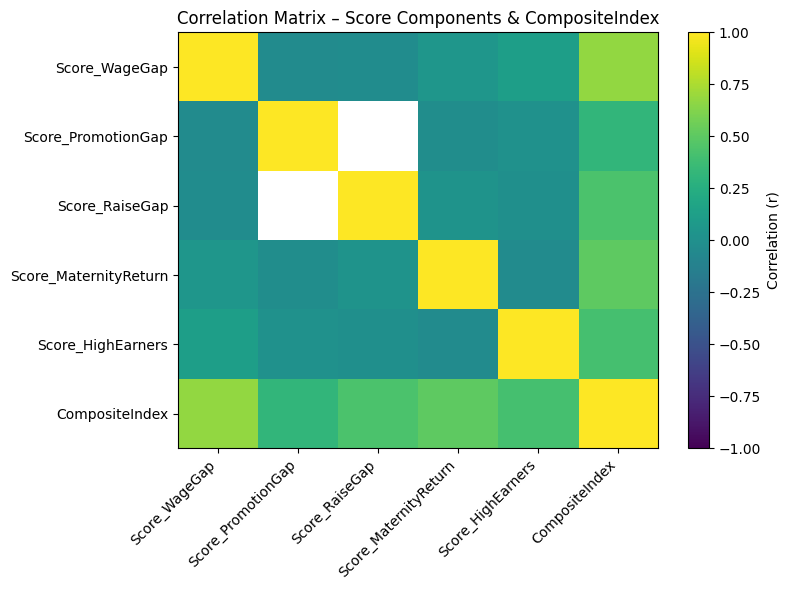

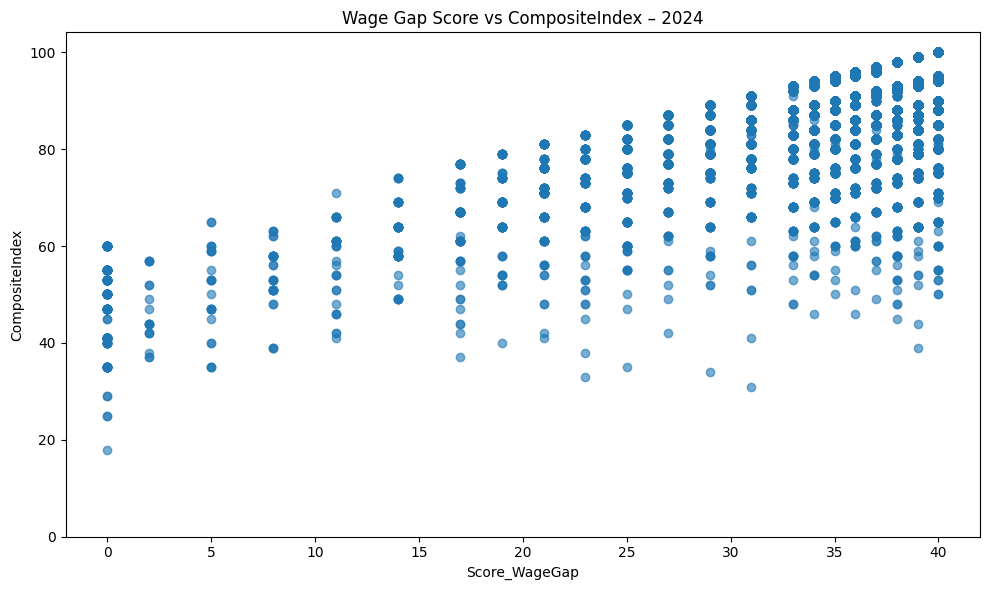

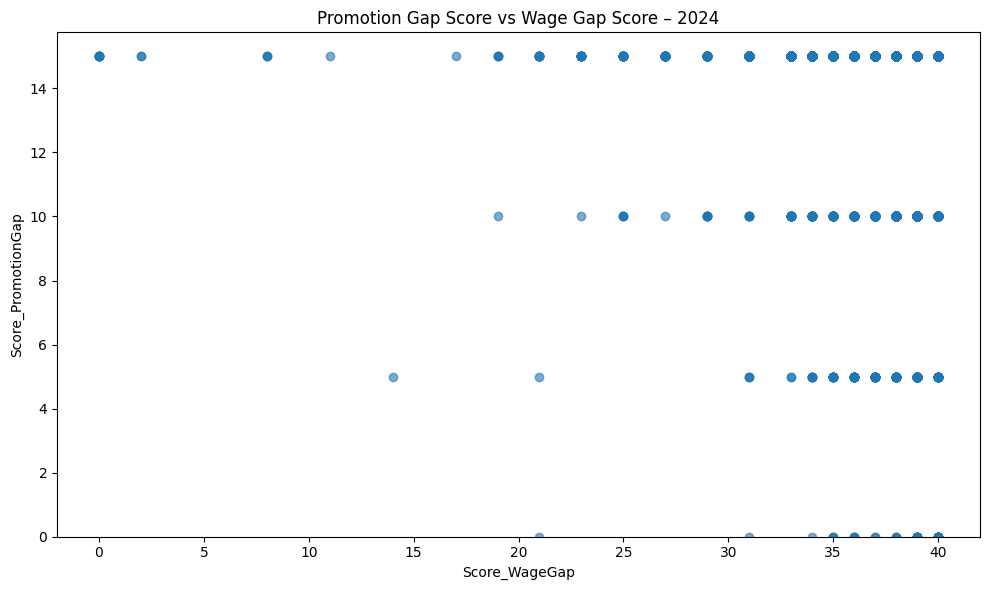

In [23]:
# Use all score columns for correlation (across all years)
corr_scores = long_df[score_cols].corr()

print("\n=== Correlation matrix among scores ===")
print(corr_scores)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr_scores, vmin=-1, vmax=1, aspect="auto")
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha="right")
plt.yticks(range(len(score_cols)), score_cols)
plt.title("Correlation Matrix – Score Components & CompositeIndex")
cbar = plt.colorbar(im)
cbar.set_label("Correlation (r)")
plt.tight_layout()
plt.show()

# Scatter: wage gap score vs CompositeIndex (latest year)
latest_scores = long_df.loc[latest_mask, ["Score_WageGap", "CompositeIndex"]].dropna()

plt.figure()
plt.scatter(latest_scores["Score_WageGap"],
            latest_scores["CompositeIndex"],
            alpha=0.6)
plt.title(f"Wage Gap Score vs CompositeIndex – {latest_year}")
plt.xlabel("Score_WageGap")
plt.ylabel("CompositeIndex")
plt.ylim(0)
plt.tight_layout()
plt.show()

# Scatter: promotion gap vs wage gap (latest year)
latest_pw = long_df.loc[latest_mask,
                        ["Score_WageGap", "Score_PromotionGap"]].dropna()
plt.figure()
plt.scatter(latest_pw["Score_WageGap"],
            latest_pw["Score_PromotionGap"],
            alpha=0.6)
plt.title(f"Promotion Gap Score vs Wage Gap Score – {latest_year}")
plt.xlabel("Score_WageGap")
plt.ylabel("Score_PromotionGap")
plt.ylim(0)
plt.tight_layout()
plt.show()



=== Correlation matrix among scores ===
                       Score_WageGap  Score_PromotionGap  Score_RaiseGap  \
Score_WageGap               1.000000           -0.036475       -0.030565   
Score_PromotionGap         -0.036475            1.000000             NaN   
Score_RaiseGap             -0.030565                 NaN        1.000000   
Score_MaternityReturn       0.050034           -0.018347        0.030431   
Score_HighEarners           0.124707            0.009331       -0.005286   
CompositeIndex              0.678003            0.313056        0.433928   

                       Score_MaternityReturn  Score_HighEarners  \
Score_WageGap                       0.050034           0.124707   
Score_PromotionGap                 -0.018347           0.009331   
Score_RaiseGap                      0.030431          -0.005286   
Score_MaternityReturn               1.000000          -0.038540   
Score_HighEarners                  -0.038540           1.000000   
CompositeIndex          

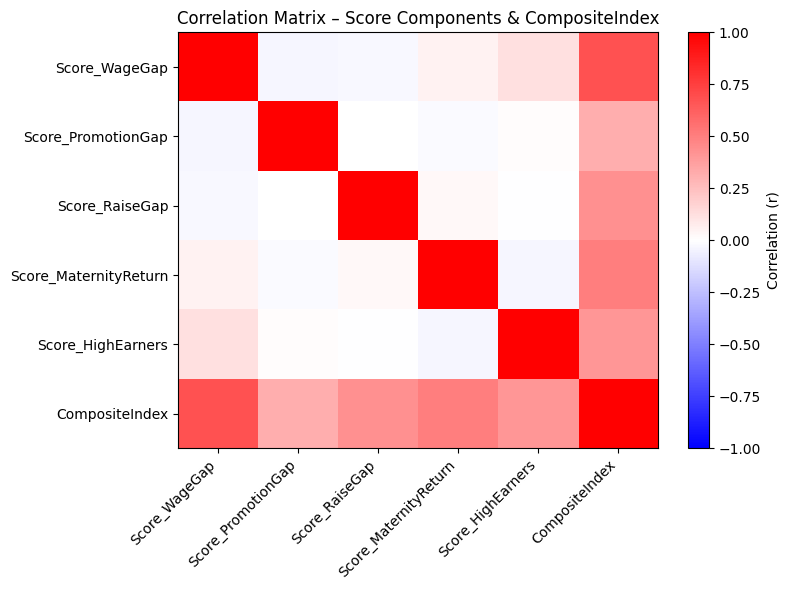

In [24]:
# Use all score columns for correlation (across all years)
corr_scores = long_df[score_cols].corr()

print("\n=== Correlation matrix among scores ===")
print(corr_scores)

plt.figure(figsize=(8, 6))

# Updated color scale: -1 = red, 0 = white, 1 = blue
im = plt.imshow(
    corr_scores,
    vmin=-1,
    vmax=1,
    cmap="bwr",   # diverging red–white–blue scale
    aspect="auto"
)

plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha="right")
plt.yticks(range(len(score_cols)), score_cols)
plt.title("Correlation Matrix – Score Components & CompositeIndex")

# Add colorbar with label
cbar = plt.colorbar(im)
cbar.set_label("Correlation (r)")

plt.tight_layout()
plt.show()



=== Correlation matrix among scores ===
                       Score_WageGap  Score_PromotionGap  Score_RaiseGap  \
Score_WageGap               1.000000           -0.036475       -0.030565   
Score_PromotionGap         -0.036475            1.000000             NaN   
Score_RaiseGap             -0.030565                 NaN        1.000000   
Score_MaternityReturn       0.050034           -0.018347        0.030431   
Score_HighEarners           0.124707            0.009331       -0.005286   
CompositeIndex              0.678003            0.313056        0.433928   

                       Score_MaternityReturn  Score_HighEarners  \
Score_WageGap                       0.050034           0.124707   
Score_PromotionGap                 -0.018347           0.009331   
Score_RaiseGap                      0.030431          -0.005286   
Score_MaternityReturn               1.000000          -0.038540   
Score_HighEarners                  -0.038540           1.000000   
CompositeIndex          

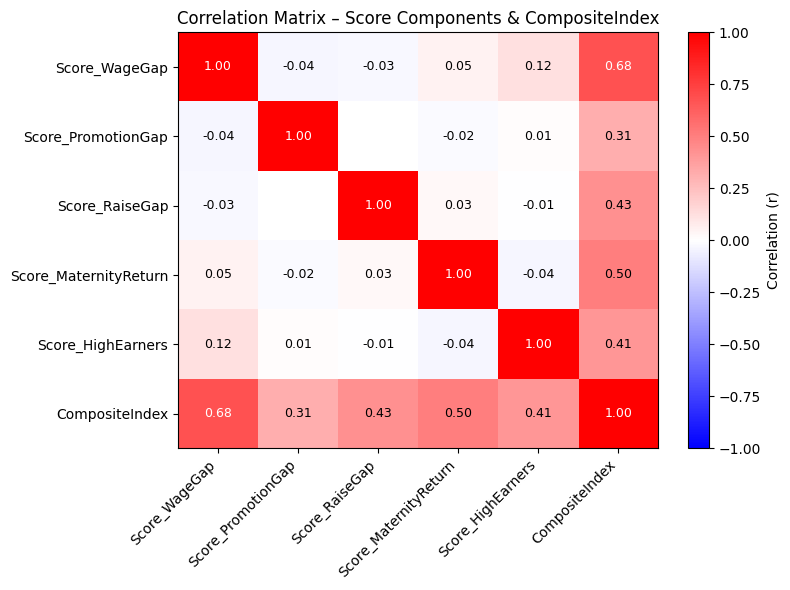

In [25]:
# Use all score columns for correlation (across all years)
corr_scores = long_df[score_cols].corr()

print("\n=== Correlation matrix among scores ===")
print(corr_scores)

plt.figure(figsize=(8, 6))

# Updated color scale: -1 = red, 0 = white, 1 = blue
im = plt.imshow(
    corr_scores,
    vmin=-1,
    vmax=1,
    cmap="bwr",   # diverging red–white–blue scale
    aspect="auto"
)

plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha="right")
plt.yticks(range(len(score_cols)), score_cols)
plt.title("Correlation Matrix – Score Components & CompositeIndex")

# Add colorbar with label
cbar = plt.colorbar(im)
cbar.set_label("Correlation (r)")

#Add numeric annotations
for i in range(len(score_cols)):
    for j in range(len(score_cols)):
        value = corr_scores.iloc[i, j]
        plt.text(
            j, i,
            f"{value:.2f}",          # format to 2 decimals
            ha="center", va="center",
            color="black" if abs(value) < 0.6 else "white",  # contrast text color
            fontsize=9
        )

plt.tight_layout()
plt.show()


**Top & Bottom Companies (CompositeIndex)**

What this shows:

Which companies are leaders vs laggards in gender pay equity, based on France’s own CompositeIndex

Great for “naming and faming/shaming” or focused case studies

In [ ]:
latest_ci_all = long_df.loc[latest_mask, ["EmployerId", "CompositeIndex"]].dropna()

top_20 = latest_ci_all.sort_values("CompositeIndex", ascending=False).head(20)
bottom_20 = latest_ci_all.sort_values("CompositeIndex", ascending=True).head(20)

print(f"\n=== Top 20 Employers by CompositeIndex – {latest_year} ===")
print(top_20)

print(f"\n=== Bottom 20 Employers by CompositeIndex – {latest_year} ===")
print(bottom_20)



=== Top 20 Employers by CompositeIndex – 2024 ===
        EmployerId  CompositeIndex
251089   388439184           100.0
266175   538806084           100.0
251174   388927022           100.0
266123   538592312           100.0
274752   819969858           100.0
277142   880687967           100.0
274750   819958463           100.0
251015   388190175           100.0
251041   388276180           100.0
251042   388278491           100.0
266259   539939462           100.0
245522   334236486           100.0
261721   489819748           100.0
255459   418872537           100.0
266341   542062211           100.0
250876   387020522           100.0
266319   542046677           100.0
250989   388069247           100.0
259862   451533715           100.0
255554   419574157           100.0

=== Bottom 20 Employers by CompositeIndex – 2024 ===
        EmployerId  CompositeIndex
242853   319633749            18.0
250747   384956884            25.0
265020   523666063            25.0
262667   498582030  

**Regional View**

What this shows:

Whether certain regions or départements systematically perform better/worse on CompositeIndex

Useful for geography-level policy conversations


=== Average CompositeIndex by Region – 2024 ===
Region
Corse                         91.173333
Guadeloupe                    89.934783
La Réunion                    89.513661
Nouvelle-Aquitaine            89.494286
Centre-Val de Loire           89.316225
Guyane                        89.153846
Bretagne                      89.125000
Grand-Est                     88.904580
Pays de la Loire              88.896844
Bourgogne-Franche-Comté       88.785381
Hauts-de-France               88.726923
Normandie                     88.620419
Occitanie                     88.531019
Provence-Alpes-Côte d'Azur    88.316960
Martinique                    88.059701
Auvergne-Rhône-Alpes          88.056309
Île-de-France                 87.425353
Mayotte                       81.166667
Name: CompositeIndex, dtype: float64


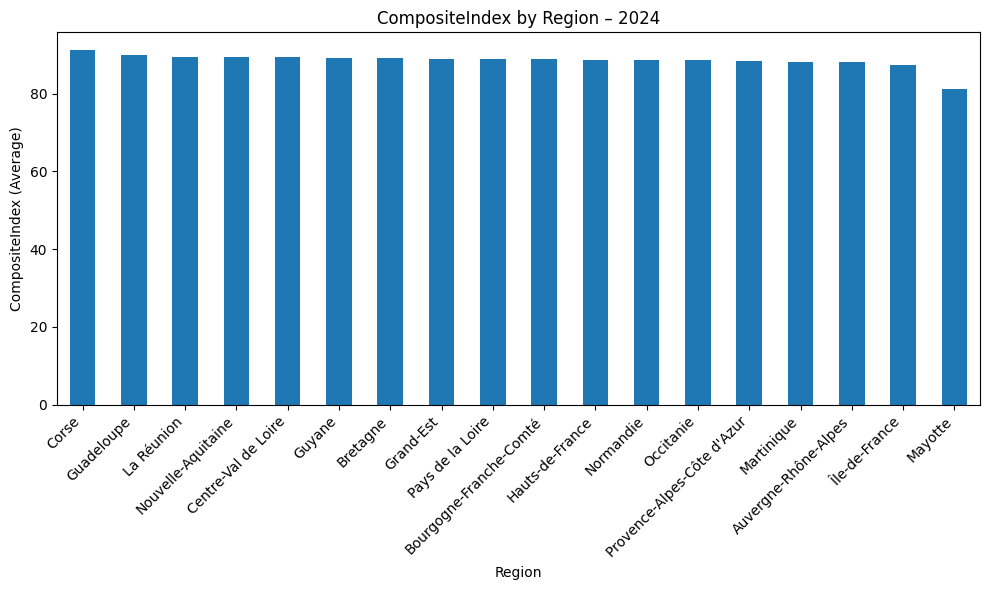

In [ ]:
if "Region" in long_df.columns:
    latest_region = long_df.loc[latest_mask].dropna(subset=["Region"])
    reg_ci = (
        latest_region.groupby("Region")["CompositeIndex"]
        .mean()
        .sort_values(ascending=False)
    )

    print(f"\n=== Average CompositeIndex by Region – {latest_year} ===")
    print(reg_ci.head(20))

    plt.figure(figsize=(10, 6))
    reg_ci.plot(kind="bar")
    plt.title(f"CompositeIndex by Region – {latest_year}")
    plt.xlabel("Region")
    plt.ylabel("CompositeIndex (Average)")
    plt.ylim(0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
